# GM-VAE for SMBA

In [1]:
num_components=2
num_epochs=10000

In [2]:
%load_ext autoreload
%autoreload 2

## Import Libraries

In [3]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
sys.path.append('../experiments/')
import vglc_with_path_encodings
import smba_gmprior_effect_on_rec

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [4]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [5]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [6]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [7]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [8]:
np.random.seed(42)
smb_labels = np.random.randint(num_components, size=smb_onehot.shape[0])
smb_labels.shape, smb_labels[:20]

((2698,), array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]))

In [9]:
chunks, labels = smb_onehot, smb_labels

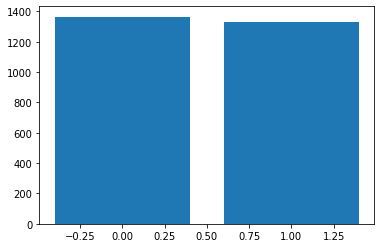

In [10]:
plt.bar(np.arange(num_components), np.bincount(smb_labels))
plt.show()

## Input Parameters

In [11]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [12]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [13]:
from torch.utils.data import TensorDataset, DataLoader

In [14]:
valid_indices = np.random.randint(len(chunks), size=500)
train_chunks, valid_chunks = chunks, chunks[valid_indices]
train_labels, valid_labels = labels, labels[valid_indices]

train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

In [15]:
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)

## Train Model

In [17]:
# Model Initialization
gmvae = GMVAE(args)

In [32]:
# history_loss = gmvae.train(train_dl, valid_dl)

(Epoch 1 / 10000) Train_Loss: 457.571; Val_Loss: 228.421   Train_ACC: 50.074; Val_ACC: 52.200   Train_NMI: 0.039; Val_NMI: -0.000
(Epoch 2 / 10000) Train_Loss: 231.706; Val_Loss: 222.308   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3 / 10000) Train_Loss: 227.661; Val_Loss: 216.323   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4 / 10000) Train_Loss: 219.783; Val_Loss: 210.561   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5 / 10000) Train_Loss: 216.096; Val_Loss: 208.129   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6 / 10000) Train_Loss: 212.559; Val_Loss: 205.747   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7 / 10000) Train_Loss: 208.981; Val_Loss: 203.573   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8 / 10000) Train_Loss: 208.338; Val_Loss: 200.648   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 64 / 10000) Train_Loss: 126.644; Val_Loss: 121.472   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 65 / 10000) Train_Loss: 125.160; Val_Loss: 120.851   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 66 / 10000) Train_Loss: 126.446; Val_Loss: 121.322   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 67 / 10000) Train_Loss: 125.068; Val_Loss: 120.803   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 68 / 10000) Train_Loss: 123.406; Val_Loss: 120.780   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 69 / 10000) Train_Loss: 123.727; Val_Loss: 119.391   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 70 / 10000) Train_Loss: 124.169; Val_Loss: 119.923   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 71 / 10000) Train_Loss: 122.863; Val_Loss: 119.573   Train_ACC: 50.593; Val_

(Epoch 127 / 10000) Train_Loss: 92.245; Val_Loss: 87.397   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 128 / 10000) Train_Loss: 91.136; Val_Loss: 85.342   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 129 / 10000) Train_Loss: 90.705; Val_Loss: 84.624   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 130 / 10000) Train_Loss: 90.163; Val_Loss: 87.786   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 131 / 10000) Train_Loss: 91.052; Val_Loss: 86.814   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 132 / 10000) Train_Loss: 90.691; Val_Loss: 84.964   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 133 / 10000) Train_Loss: 92.226; Val_Loss: 84.586   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 134 / 10000) Train_Loss: 89.668; Val_Loss: 84.272   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 191 / 10000) Train_Loss: 71.361; Val_Loss: 66.504   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 192 / 10000) Train_Loss: 72.388; Val_Loss: 67.120   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 193 / 10000) Train_Loss: 72.278; Val_Loss: 66.689   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 194 / 10000) Train_Loss: 70.567; Val_Loss: 66.248   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 195 / 10000) Train_Loss: 70.594; Val_Loss: 65.504   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 196 / 10000) Train_Loss: 69.965; Val_Loss: 65.686   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 197 / 10000) Train_Loss: 70.026; Val_Loss: 66.582   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 198 / 10000) Train_Loss: 70.807; Val_Loss: 66.124   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 255 / 10000) Train_Loss: 61.935; Val_Loss: 58.354   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 256 / 10000) Train_Loss: 61.303; Val_Loss: 58.095   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 257 / 10000) Train_Loss: 59.851; Val_Loss: 55.540   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 258 / 10000) Train_Loss: 61.283; Val_Loss: 61.664   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 259 / 10000) Train_Loss: 60.011; Val_Loss: 57.005   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 260 / 10000) Train_Loss: 59.563; Val_Loss: 57.606   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 261 / 10000) Train_Loss: 59.630; Val_Loss: 54.511   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 262 / 10000) Train_Loss: 58.627; Val_Loss: 54.958   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 319 / 10000) Train_Loss: 53.168; Val_Loss: 50.400   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 320 / 10000) Train_Loss: 53.537; Val_Loss: 51.509   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 321 / 10000) Train_Loss: 54.553; Val_Loss: 51.054   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 322 / 10000) Train_Loss: 56.796; Val_Loss: 55.086   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 323 / 10000) Train_Loss: 57.834; Val_Loss: 56.894   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 324 / 10000) Train_Loss: 57.488; Val_Loss: 52.208   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 325 / 10000) Train_Loss: 55.738; Val_Loss: 50.925   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 326 / 10000) Train_Loss: 53.918; Val_Loss: 50.408   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 383 / 10000) Train_Loss: 49.828; Val_Loss: 45.262   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 384 / 10000) Train_Loss: 48.177; Val_Loss: 45.578   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 385 / 10000) Train_Loss: 48.000; Val_Loss: 46.338   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 386 / 10000) Train_Loss: 48.813; Val_Loss: 45.564   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 387 / 10000) Train_Loss: 48.172; Val_Loss: 46.519   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 388 / 10000) Train_Loss: 47.505; Val_Loss: 45.612   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 389 / 10000) Train_Loss: 48.454; Val_Loss: 47.670   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 390 / 10000) Train_Loss: 48.576; Val_Loss: 46.662   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 447 / 10000) Train_Loss: 48.667; Val_Loss: 44.576   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 448 / 10000) Train_Loss: 47.245; Val_Loss: 47.176   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 449 / 10000) Train_Loss: 48.037; Val_Loss: 43.548   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 450 / 10000) Train_Loss: 47.818; Val_Loss: 44.915   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 451 / 10000) Train_Loss: 49.918; Val_Loss: 46.307   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 452 / 10000) Train_Loss: 50.599; Val_Loss: 51.886   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 453 / 10000) Train_Loss: 49.390; Val_Loss: 46.624   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 454 / 10000) Train_Loss: 49.985; Val_Loss: 45.973   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 511 / 10000) Train_Loss: 43.123; Val_Loss: 40.696   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 512 / 10000) Train_Loss: 44.276; Val_Loss: 41.567   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 513 / 10000) Train_Loss: 43.897; Val_Loss: 41.487   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 514 / 10000) Train_Loss: 46.591; Val_Loss: 43.338   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 515 / 10000) Train_Loss: 44.982; Val_Loss: 41.641   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 516 / 10000) Train_Loss: 43.382; Val_Loss: 41.786   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 517 / 10000) Train_Loss: 43.035; Val_Loss: 40.583   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 518 / 10000) Train_Loss: 42.734; Val_Loss: 41.285   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 575 / 10000) Train_Loss: 40.934; Val_Loss: 39.400   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 576 / 10000) Train_Loss: 40.696; Val_Loss: 39.751   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 577 / 10000) Train_Loss: 41.310; Val_Loss: 41.286   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 578 / 10000) Train_Loss: 44.618; Val_Loss: 42.742   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 579 / 10000) Train_Loss: 42.448; Val_Loss: 39.489   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 580 / 10000) Train_Loss: 42.395; Val_Loss: 40.160   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 581 / 10000) Train_Loss: 44.387; Val_Loss: 42.329   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 582 / 10000) Train_Loss: 48.078; Val_Loss: 43.943   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 639 / 10000) Train_Loss: 40.430; Val_Loss: 37.659   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 640 / 10000) Train_Loss: 39.755; Val_Loss: 38.794   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 641 / 10000) Train_Loss: 40.488; Val_Loss: 39.221   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 642 / 10000) Train_Loss: 41.282; Val_Loss: 40.354   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 643 / 10000) Train_Loss: 43.415; Val_Loss: 44.110   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 644 / 10000) Train_Loss: 42.382; Val_Loss: 41.863   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 645 / 10000) Train_Loss: 41.702; Val_Loss: 39.610   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 646 / 10000) Train_Loss: 41.409; Val_Loss: 39.038   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 703 / 10000) Train_Loss: 41.939; Val_Loss: 40.176   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 704 / 10000) Train_Loss: 41.487; Val_Loss: 41.630   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 705 / 10000) Train_Loss: 43.408; Val_Loss: 41.378   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 706 / 10000) Train_Loss: 42.306; Val_Loss: 38.288   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 707 / 10000) Train_Loss: 39.619; Val_Loss: 39.520   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 708 / 10000) Train_Loss: 39.204; Val_Loss: 37.201   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 709 / 10000) Train_Loss: 37.943; Val_Loss: 36.669   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 710 / 10000) Train_Loss: 38.563; Val_Loss: 37.272   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 767 / 10000) Train_Loss: 39.624; Val_Loss: 39.196   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 768 / 10000) Train_Loss: 42.604; Val_Loss: 39.215   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 769 / 10000) Train_Loss: 40.682; Val_Loss: 38.576   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 770 / 10000) Train_Loss: 40.599; Val_Loss: 38.249   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 771 / 10000) Train_Loss: 41.130; Val_Loss: 38.191   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 772 / 10000) Train_Loss: 40.463; Val_Loss: 39.552   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 773 / 10000) Train_Loss: 46.858; Val_Loss: 44.022   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 774 / 10000) Train_Loss: 45.078; Val_Loss: 43.520   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 831 / 10000) Train_Loss: 43.548; Val_Loss: 40.860   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 832 / 10000) Train_Loss: 40.253; Val_Loss: 39.455   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 833 / 10000) Train_Loss: 41.273; Val_Loss: 37.995   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 834 / 10000) Train_Loss: 40.343; Val_Loss: 36.766   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 835 / 10000) Train_Loss: 39.827; Val_Loss: 36.919   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 836 / 10000) Train_Loss: 37.040; Val_Loss: 35.703   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 837 / 10000) Train_Loss: 37.187; Val_Loss: 35.505   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 838 / 10000) Train_Loss: 42.704; Val_Loss: 40.736   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 895 / 10000) Train_Loss: 39.263; Val_Loss: 36.619   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 896 / 10000) Train_Loss: 39.362; Val_Loss: 43.154   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 897 / 10000) Train_Loss: 50.092; Val_Loss: 47.255   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 898 / 10000) Train_Loss: 41.952; Val_Loss: 40.302   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 899 / 10000) Train_Loss: 39.392; Val_Loss: 36.407   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 900 / 10000) Train_Loss: 38.079; Val_Loss: 36.118   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 901 / 10000) Train_Loss: 37.357; Val_Loss: 36.764   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 902 / 10000) Train_Loss: 38.763; Val_Loss: 36.015   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 959 / 10000) Train_Loss: 37.171; Val_Loss: 36.236   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 960 / 10000) Train_Loss: 36.451; Val_Loss: 34.201   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 961 / 10000) Train_Loss: 37.548; Val_Loss: 36.302   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 962 / 10000) Train_Loss: 38.945; Val_Loss: 35.710   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 963 / 10000) Train_Loss: 37.308; Val_Loss: 38.619   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 964 / 10000) Train_Loss: 39.214; Val_Loss: 35.960   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 965 / 10000) Train_Loss: 36.621; Val_Loss: 35.120   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 966 / 10000) Train_Loss: 36.183; Val_Loss: 36.257   Train_ACC: 50.593; Val_ACC: 52.

(Epoch 1022 / 10000) Train_Loss: 35.376; Val_Loss: 35.486   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1023 / 10000) Train_Loss: 37.115; Val_Loss: 35.300   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1024 / 10000) Train_Loss: 36.365; Val_Loss: 35.862   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1025 / 10000) Train_Loss: 35.786; Val_Loss: 35.464   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1026 / 10000) Train_Loss: 36.328; Val_Loss: 33.890   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1027 / 10000) Train_Loss: 35.911; Val_Loss: 35.773   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1028 / 10000) Train_Loss: 36.011; Val_Loss: 34.447   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1029 / 10000) Train_Loss: 36.111; Val_Loss: 34.700   Train_ACC: 50.593; Val_

(Epoch 1085 / 10000) Train_Loss: 36.209; Val_Loss: 34.337   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1086 / 10000) Train_Loss: 35.160; Val_Loss: 33.292   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1087 / 10000) Train_Loss: 34.520; Val_Loss: 34.042   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1088 / 10000) Train_Loss: 34.983; Val_Loss: 34.421   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1089 / 10000) Train_Loss: 35.445; Val_Loss: 34.194   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1090 / 10000) Train_Loss: 35.420; Val_Loss: 35.239   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1091 / 10000) Train_Loss: 34.958; Val_Loss: 33.509   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1092 / 10000) Train_Loss: 34.365; Val_Loss: 35.198   Train_ACC: 50.593; Val_

(Epoch 1148 / 10000) Train_Loss: 35.245; Val_Loss: 34.423   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1149 / 10000) Train_Loss: 34.588; Val_Loss: 33.682   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1150 / 10000) Train_Loss: 34.864; Val_Loss: 34.012   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1151 / 10000) Train_Loss: 35.202; Val_Loss: 35.599   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1152 / 10000) Train_Loss: 35.403; Val_Loss: 35.808   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1153 / 10000) Train_Loss: 39.289; Val_Loss: 36.620   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1154 / 10000) Train_Loss: 38.225; Val_Loss: 36.156   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1155 / 10000) Train_Loss: 38.698; Val_Loss: 36.331   Train_ACC: 50.593; Val_

(Epoch 1211 / 10000) Train_Loss: 35.049; Val_Loss: 34.942   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1212 / 10000) Train_Loss: 34.303; Val_Loss: 33.549   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1213 / 10000) Train_Loss: 36.058; Val_Loss: 33.365   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1214 / 10000) Train_Loss: 34.865; Val_Loss: 34.829   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1215 / 10000) Train_Loss: 37.867; Val_Loss: 35.495   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1216 / 10000) Train_Loss: 36.908; Val_Loss: 35.049   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1217 / 10000) Train_Loss: 34.902; Val_Loss: 34.263   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1218 / 10000) Train_Loss: 37.122; Val_Loss: 36.259   Train_ACC: 50.593; Val_

(Epoch 1274 / 10000) Train_Loss: 38.500; Val_Loss: 39.090   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1275 / 10000) Train_Loss: 41.063; Val_Loss: 38.174   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1276 / 10000) Train_Loss: 38.088; Val_Loss: 36.961   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1277 / 10000) Train_Loss: 37.262; Val_Loss: 33.080   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1278 / 10000) Train_Loss: 34.568; Val_Loss: 33.587   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1279 / 10000) Train_Loss: 34.233; Val_Loss: 32.642   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1280 / 10000) Train_Loss: 33.832; Val_Loss: 32.933   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1281 / 10000) Train_Loss: 34.789; Val_Loss: 33.647   Train_ACC: 50.593; Val_

(Epoch 1337 / 10000) Train_Loss: 34.265; Val_Loss: 33.080   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1338 / 10000) Train_Loss: 33.837; Val_Loss: 32.351   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1339 / 10000) Train_Loss: 34.220; Val_Loss: 33.110   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1340 / 10000) Train_Loss: 33.009; Val_Loss: 32.148   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1341 / 10000) Train_Loss: 32.821; Val_Loss: 32.312   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1342 / 10000) Train_Loss: 33.006; Val_Loss: 32.798   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1343 / 10000) Train_Loss: 34.653; Val_Loss: 33.593   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1344 / 10000) Train_Loss: 35.811; Val_Loss: 37.188   Train_ACC: 50.593; Val_

(Epoch 1401 / 10000) Train_Loss: 35.156; Val_Loss: 33.915   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1402 / 10000) Train_Loss: 34.829; Val_Loss: 35.021   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1403 / 10000) Train_Loss: 34.619; Val_Loss: 33.962   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1404 / 10000) Train_Loss: 33.910; Val_Loss: 33.924   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1405 / 10000) Train_Loss: 36.162; Val_Loss: 34.681   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1406 / 10000) Train_Loss: 38.982; Val_Loss: 37.153   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1407 / 10000) Train_Loss: 39.297; Val_Loss: 35.899   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1408 / 10000) Train_Loss: 35.949; Val_Loss: 33.628   Train_ACC: 50.593; Val_

(Epoch 1573 / 10000) Train_Loss: 35.132; Val_Loss: 33.185   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1574 / 10000) Train_Loss: 33.777; Val_Loss: 32.528   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1575 / 10000) Train_Loss: 33.359; Val_Loss: 32.474   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1576 / 10000) Train_Loss: 33.061; Val_Loss: 32.573   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1577 / 10000) Train_Loss: 32.977; Val_Loss: 32.404   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1578 / 10000) Train_Loss: 33.711; Val_Loss: 32.173   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1579 / 10000) Train_Loss: 34.251; Val_Loss: 34.590   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1580 / 10000) Train_Loss: 35.735; Val_Loss: 34.145   Train_ACC: 50.593; Val_

(Epoch 1636 / 10000) Train_Loss: 35.635; Val_Loss: 34.077   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1637 / 10000) Train_Loss: 37.931; Val_Loss: 45.701   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1638 / 10000) Train_Loss: 44.523; Val_Loss: 38.297   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1639 / 10000) Train_Loss: 40.268; Val_Loss: 35.913   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1640 / 10000) Train_Loss: 34.903; Val_Loss: 32.348   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1641 / 10000) Train_Loss: 33.206; Val_Loss: 32.759   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1642 / 10000) Train_Loss: 33.578; Val_Loss: 32.082   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1643 / 10000) Train_Loss: 33.300; Val_Loss: 32.383   Train_ACC: 50.593; Val_

(Epoch 1699 / 10000) Train_Loss: 33.290; Val_Loss: 33.072   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1700 / 10000) Train_Loss: 33.351; Val_Loss: 32.556   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1701 / 10000) Train_Loss: 35.382; Val_Loss: 38.589   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1702 / 10000) Train_Loss: 36.693; Val_Loss: 34.409   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1703 / 10000) Train_Loss: 34.961; Val_Loss: 33.127   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1704 / 10000) Train_Loss: 33.564; Val_Loss: 32.486   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1705 / 10000) Train_Loss: 34.676; Val_Loss: 33.689   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1706 / 10000) Train_Loss: 33.545; Val_Loss: 32.952   Train_ACC: 50.593; Val_

(Epoch 1762 / 10000) Train_Loss: 34.137; Val_Loss: 32.587   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1763 / 10000) Train_Loss: 32.830; Val_Loss: 32.740   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1764 / 10000) Train_Loss: 33.417; Val_Loss: 33.471   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1765 / 10000) Train_Loss: 34.518; Val_Loss: 33.397   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1766 / 10000) Train_Loss: 33.158; Val_Loss: 32.032   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1767 / 10000) Train_Loss: 32.978; Val_Loss: 31.937   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1768 / 10000) Train_Loss: 33.288; Val_Loss: 32.825   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1769 / 10000) Train_Loss: 33.200; Val_Loss: 34.097   Train_ACC: 50.593; Val_

(Epoch 1825 / 10000) Train_Loss: 33.483; Val_Loss: 31.673   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1826 / 10000) Train_Loss: 33.147; Val_Loss: 33.375   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1827 / 10000) Train_Loss: 34.045; Val_Loss: 32.671   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1828 / 10000) Train_Loss: 33.462; Val_Loss: 32.099   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1829 / 10000) Train_Loss: 32.999; Val_Loss: 31.452   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1830 / 10000) Train_Loss: 32.410; Val_Loss: 32.477   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1831 / 10000) Train_Loss: 32.575; Val_Loss: 32.660   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1832 / 10000) Train_Loss: 32.690; Val_Loss: 31.255   Train_ACC: 50.593; Val_

(Epoch 1888 / 10000) Train_Loss: 33.167; Val_Loss: 39.382   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1889 / 10000) Train_Loss: 37.587; Val_Loss: 35.744   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1890 / 10000) Train_Loss: 36.671; Val_Loss: 33.734   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1891 / 10000) Train_Loss: 34.344; Val_Loss: 34.024   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1892 / 10000) Train_Loss: 33.729; Val_Loss: 33.489   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1893 / 10000) Train_Loss: 35.568; Val_Loss: 33.185   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1894 / 10000) Train_Loss: 32.628; Val_Loss: 33.290   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1895 / 10000) Train_Loss: 32.903; Val_Loss: 32.472   Train_ACC: 50.593; Val_

(Epoch 1951 / 10000) Train_Loss: 32.618; Val_Loss: 31.736   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1952 / 10000) Train_Loss: 32.666; Val_Loss: 32.730   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1953 / 10000) Train_Loss: 32.735; Val_Loss: 32.023   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1954 / 10000) Train_Loss: 32.897; Val_Loss: 31.698   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1955 / 10000) Train_Loss: 32.919; Val_Loss: 32.270   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1956 / 10000) Train_Loss: 32.133; Val_Loss: 32.062   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1957 / 10000) Train_Loss: 33.351; Val_Loss: 31.229   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 1958 / 10000) Train_Loss: 32.431; Val_Loss: 31.507   Train_ACC: 50.593; Val_

(Epoch 2014 / 10000) Train_Loss: 36.133; Val_Loss: 34.566   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2015 / 10000) Train_Loss: 37.684; Val_Loss: 38.995   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2016 / 10000) Train_Loss: 59.538; Val_Loss: 53.422   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2017 / 10000) Train_Loss: 48.151; Val_Loss: 39.271   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2018 / 10000) Train_Loss: 37.871; Val_Loss: 33.876   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2019 / 10000) Train_Loss: 34.038; Val_Loss: 31.937   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2020 / 10000) Train_Loss: 32.434; Val_Loss: 33.301   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2021 / 10000) Train_Loss: 32.554; Val_Loss: 32.284   Train_ACC: 50.593; Val_

(Epoch 2077 / 10000) Train_Loss: 31.579; Val_Loss: 31.343   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2078 / 10000) Train_Loss: 31.565; Val_Loss: 31.537   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2079 / 10000) Train_Loss: 32.045; Val_Loss: 30.599   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2080 / 10000) Train_Loss: 31.888; Val_Loss: 31.611   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2081 / 10000) Train_Loss: 33.853; Val_Loss: 32.279   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2082 / 10000) Train_Loss: 32.556; Val_Loss: 31.516   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2083 / 10000) Train_Loss: 33.024; Val_Loss: 33.547   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2084 / 10000) Train_Loss: 33.749; Val_Loss: 31.687   Train_ACC: 50.593; Val_

(Epoch 2140 / 10000) Train_Loss: 32.139; Val_Loss: 31.339   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2141 / 10000) Train_Loss: 31.580; Val_Loss: 30.521   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2142 / 10000) Train_Loss: 32.102; Val_Loss: 32.037   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2143 / 10000) Train_Loss: 34.850; Val_Loss: 33.404   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2144 / 10000) Train_Loss: 32.798; Val_Loss: 32.225   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2145 / 10000) Train_Loss: 32.826; Val_Loss: 32.802   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2146 / 10000) Train_Loss: 32.796; Val_Loss: 31.376   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2147 / 10000) Train_Loss: 32.612; Val_Loss: 32.812   Train_ACC: 50.593; Val_

(Epoch 2203 / 10000) Train_Loss: 31.795; Val_Loss: 30.729   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2204 / 10000) Train_Loss: 33.000; Val_Loss: 31.757   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2205 / 10000) Train_Loss: 32.553; Val_Loss: 31.944   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2206 / 10000) Train_Loss: 34.746; Val_Loss: 33.302   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2207 / 10000) Train_Loss: 34.210; Val_Loss: 32.271   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2208 / 10000) Train_Loss: 33.878; Val_Loss: 34.122   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2209 / 10000) Train_Loss: 33.480; Val_Loss: 32.456   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2210 / 10000) Train_Loss: 34.353; Val_Loss: 32.236   Train_ACC: 50.593; Val_

(Epoch 2266 / 10000) Train_Loss: 33.131; Val_Loss: 33.400   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2267 / 10000) Train_Loss: 32.731; Val_Loss: 35.019   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2268 / 10000) Train_Loss: 33.060; Val_Loss: 31.020   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2269 / 10000) Train_Loss: 33.600; Val_Loss: 35.105   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2270 / 10000) Train_Loss: 34.457; Val_Loss: 32.620   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2271 / 10000) Train_Loss: 33.569; Val_Loss: 32.057   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2272 / 10000) Train_Loss: 38.000; Val_Loss: 36.407   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2273 / 10000) Train_Loss: 35.930; Val_Loss: 33.897   Train_ACC: 50.593; Val_

(Epoch 2330 / 10000) Train_Loss: 43.815; Val_Loss: 41.317   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2331 / 10000) Train_Loss: 41.548; Val_Loss: 33.950   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2332 / 10000) Train_Loss: 35.618; Val_Loss: 32.693   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2333 / 10000) Train_Loss: 32.371; Val_Loss: 31.667   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2334 / 10000) Train_Loss: 33.783; Val_Loss: 31.620   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2335 / 10000) Train_Loss: 32.951; Val_Loss: 32.114   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2336 / 10000) Train_Loss: 31.513; Val_Loss: 30.479   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2337 / 10000) Train_Loss: 32.353; Val_Loss: 31.630   Train_ACC: 50.593; Val_

(Epoch 2393 / 10000) Train_Loss: 31.868; Val_Loss: 30.783   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2394 / 10000) Train_Loss: 32.159; Val_Loss: 31.373   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2395 / 10000) Train_Loss: 33.149; Val_Loss: 32.376   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2396 / 10000) Train_Loss: 32.953; Val_Loss: 31.100   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2397 / 10000) Train_Loss: 32.370; Val_Loss: 31.471   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2398 / 10000) Train_Loss: 32.106; Val_Loss: 31.937   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2399 / 10000) Train_Loss: 38.420; Val_Loss: 40.695   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2400 / 10000) Train_Loss: 37.801; Val_Loss: 32.770   Train_ACC: 50.593; Val_

(Epoch 2456 / 10000) Train_Loss: 33.776; Val_Loss: 32.328   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2457 / 10000) Train_Loss: 33.202; Val_Loss: 31.678   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2458 / 10000) Train_Loss: 32.346; Val_Loss: 33.239   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2459 / 10000) Train_Loss: 35.159; Val_Loss: 32.624   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2460 / 10000) Train_Loss: 32.454; Val_Loss: 31.873   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2461 / 10000) Train_Loss: 33.876; Val_Loss: 34.022   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2462 / 10000) Train_Loss: 32.704; Val_Loss: 31.734   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2463 / 10000) Train_Loss: 33.895; Val_Loss: 32.018   Train_ACC: 50.593; Val_

(Epoch 2519 / 10000) Train_Loss: 32.719; Val_Loss: 31.081   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2520 / 10000) Train_Loss: 31.361; Val_Loss: 30.626   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2521 / 10000) Train_Loss: 31.519; Val_Loss: 30.239   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2522 / 10000) Train_Loss: 33.022; Val_Loss: 31.460   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2523 / 10000) Train_Loss: 32.027; Val_Loss: 30.746   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2524 / 10000) Train_Loss: 33.265; Val_Loss: 33.403   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2525 / 10000) Train_Loss: 32.917; Val_Loss: 34.268   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2526 / 10000) Train_Loss: 34.429; Val_Loss: 33.503   Train_ACC: 50.593; Val_

(Epoch 2582 / 10000) Train_Loss: 34.937; Val_Loss: 31.977   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2583 / 10000) Train_Loss: 31.779; Val_Loss: 30.409   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2584 / 10000) Train_Loss: 31.820; Val_Loss: 32.032   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2585 / 10000) Train_Loss: 33.601; Val_Loss: 32.177   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2586 / 10000) Train_Loss: 37.667; Val_Loss: 33.727   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2587 / 10000) Train_Loss: 35.020; Val_Loss: 32.985   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2588 / 10000) Train_Loss: 34.091; Val_Loss: 33.888   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2589 / 10000) Train_Loss: 32.883; Val_Loss: 32.432   Train_ACC: 50.593; Val_

(Epoch 2645 / 10000) Train_Loss: 30.882; Val_Loss: 30.187   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2646 / 10000) Train_Loss: 31.113; Val_Loss: 30.874   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2647 / 10000) Train_Loss: 31.677; Val_Loss: 33.081   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2648 / 10000) Train_Loss: 32.353; Val_Loss: 31.909   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2649 / 10000) Train_Loss: 31.892; Val_Loss: 32.077   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2650 / 10000) Train_Loss: 32.383; Val_Loss: 31.299   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2651 / 10000) Train_Loss: 36.491; Val_Loss: 36.145   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2652 / 10000) Train_Loss: 35.320; Val_Loss: 32.250   Train_ACC: 50.593; Val_

(Epoch 2708 / 10000) Train_Loss: 33.523; Val_Loss: 31.248   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2709 / 10000) Train_Loss: 31.193; Val_Loss: 31.328   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2710 / 10000) Train_Loss: 31.766; Val_Loss: 31.879   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2711 / 10000) Train_Loss: 32.426; Val_Loss: 32.435   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2712 / 10000) Train_Loss: 32.912; Val_Loss: 32.433   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2713 / 10000) Train_Loss: 32.157; Val_Loss: 30.840   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2714 / 10000) Train_Loss: 32.880; Val_Loss: 30.871   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2715 / 10000) Train_Loss: 32.148; Val_Loss: 31.762   Train_ACC: 50.593; Val_

(Epoch 2771 / 10000) Train_Loss: 34.445; Val_Loss: 32.534   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2772 / 10000) Train_Loss: 32.725; Val_Loss: 31.477   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2773 / 10000) Train_Loss: 33.682; Val_Loss: 33.705   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2774 / 10000) Train_Loss: 32.642; Val_Loss: 31.764   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2775 / 10000) Train_Loss: 31.335; Val_Loss: 31.301   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2776 / 10000) Train_Loss: 31.947; Val_Loss: 32.041   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2777 / 10000) Train_Loss: 31.580; Val_Loss: 29.967   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2778 / 10000) Train_Loss: 31.474; Val_Loss: 32.677   Train_ACC: 50.593; Val_

(Epoch 2834 / 10000) Train_Loss: 32.406; Val_Loss: 31.012   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2835 / 10000) Train_Loss: 32.287; Val_Loss: 31.396   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2836 / 10000) Train_Loss: 34.488; Val_Loss: 32.578   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2837 / 10000) Train_Loss: 32.362; Val_Loss: 31.320   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2838 / 10000) Train_Loss: 32.520; Val_Loss: 31.563   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2839 / 10000) Train_Loss: 32.760; Val_Loss: 31.567   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2840 / 10000) Train_Loss: 32.334; Val_Loss: 31.590   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2841 / 10000) Train_Loss: 31.505; Val_Loss: 32.527   Train_ACC: 50.593; Val_

(Epoch 2897 / 10000) Train_Loss: 32.277; Val_Loss: 30.495   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2898 / 10000) Train_Loss: 32.420; Val_Loss: 32.544   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2899 / 10000) Train_Loss: 35.401; Val_Loss: 31.467   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2900 / 10000) Train_Loss: 32.434; Val_Loss: 30.510   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2901 / 10000) Train_Loss: 32.297; Val_Loss: 30.583   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2902 / 10000) Train_Loss: 31.115; Val_Loss: 29.475   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2903 / 10000) Train_Loss: 31.504; Val_Loss: 32.098   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2904 / 10000) Train_Loss: 31.606; Val_Loss: 30.277   Train_ACC: 50.593; Val_

(Epoch 2960 / 10000) Train_Loss: 33.130; Val_Loss: 31.426   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2961 / 10000) Train_Loss: 31.479; Val_Loss: 31.048   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2962 / 10000) Train_Loss: 31.807; Val_Loss: 30.915   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2963 / 10000) Train_Loss: 31.686; Val_Loss: 30.536   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2964 / 10000) Train_Loss: 30.943; Val_Loss: 31.997   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2965 / 10000) Train_Loss: 32.924; Val_Loss: 34.238   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2966 / 10000) Train_Loss: 34.745; Val_Loss: 32.045   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 2967 / 10000) Train_Loss: 32.986; Val_Loss: 33.243   Train_ACC: 50.593; Val_

(Epoch 3023 / 10000) Train_Loss: 32.089; Val_Loss: 31.760   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3024 / 10000) Train_Loss: 32.579; Val_Loss: 31.296   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3025 / 10000) Train_Loss: 31.578; Val_Loss: 31.189   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3026 / 10000) Train_Loss: 31.313; Val_Loss: 32.216   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3027 / 10000) Train_Loss: 35.899; Val_Loss: 33.300   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3028 / 10000) Train_Loss: 32.252; Val_Loss: 31.366   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3029 / 10000) Train_Loss: 34.018; Val_Loss: 36.650   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3030 / 10000) Train_Loss: 34.475; Val_Loss: 33.253   Train_ACC: 50.593; Val_

(Epoch 3086 / 10000) Train_Loss: 33.770; Val_Loss: 31.074   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3087 / 10000) Train_Loss: 31.195; Val_Loss: 30.825   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3088 / 10000) Train_Loss: 32.242; Val_Loss: 31.264   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3089 / 10000) Train_Loss: 31.144; Val_Loss: 31.394   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3090 / 10000) Train_Loss: 31.058; Val_Loss: 31.426   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3091 / 10000) Train_Loss: 33.291; Val_Loss: 30.883   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3092 / 10000) Train_Loss: 33.817; Val_Loss: 32.394   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3093 / 10000) Train_Loss: 31.611; Val_Loss: 32.342   Train_ACC: 50.593; Val_

(Epoch 3149 / 10000) Train_Loss: 31.241; Val_Loss: 30.690   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3150 / 10000) Train_Loss: 30.932; Val_Loss: 29.396   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3151 / 10000) Train_Loss: 30.989; Val_Loss: 30.148   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3152 / 10000) Train_Loss: 30.383; Val_Loss: 29.625   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3153 / 10000) Train_Loss: 30.843; Val_Loss: 30.370   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3154 / 10000) Train_Loss: 32.019; Val_Loss: 31.221   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3155 / 10000) Train_Loss: 31.364; Val_Loss: 30.797   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3156 / 10000) Train_Loss: 31.951; Val_Loss: 31.167   Train_ACC: 50.593; Val_

(Epoch 3212 / 10000) Train_Loss: 31.170; Val_Loss: 30.624   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3213 / 10000) Train_Loss: 30.795; Val_Loss: 32.642   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3214 / 10000) Train_Loss: 32.069; Val_Loss: 30.950   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3215 / 10000) Train_Loss: 31.521; Val_Loss: 32.164   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3216 / 10000) Train_Loss: 32.070; Val_Loss: 31.880   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3217 / 10000) Train_Loss: 32.219; Val_Loss: 31.681   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3218 / 10000) Train_Loss: 31.841; Val_Loss: 31.694   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3219 / 10000) Train_Loss: 31.401; Val_Loss: 31.871   Train_ACC: 50.593; Val_

(Epoch 3275 / 10000) Train_Loss: 30.457; Val_Loss: 30.581   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3276 / 10000) Train_Loss: 32.175; Val_Loss: 31.384   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3277 / 10000) Train_Loss: 32.222; Val_Loss: 32.287   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3278 / 10000) Train_Loss: 31.759; Val_Loss: 30.669   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3279 / 10000) Train_Loss: 32.897; Val_Loss: 32.738   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3280 / 10000) Train_Loss: 33.005; Val_Loss: 31.505   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3281 / 10000) Train_Loss: 33.375; Val_Loss: 31.990   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3282 / 10000) Train_Loss: 31.574; Val_Loss: 31.078   Train_ACC: 50.593; Val_

(Epoch 3338 / 10000) Train_Loss: 31.867; Val_Loss: 30.536   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3339 / 10000) Train_Loss: 31.413; Val_Loss: 30.158   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3340 / 10000) Train_Loss: 32.634; Val_Loss: 33.801   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3341 / 10000) Train_Loss: 35.825; Val_Loss: 32.228   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3342 / 10000) Train_Loss: 35.426; Val_Loss: 33.874   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3343 / 10000) Train_Loss: 33.513; Val_Loss: 32.031   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3344 / 10000) Train_Loss: 31.492; Val_Loss: 30.482   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3345 / 10000) Train_Loss: 31.972; Val_Loss: 31.430   Train_ACC: 50.593; Val_

(Epoch 3401 / 10000) Train_Loss: 32.824; Val_Loss: 30.577   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3402 / 10000) Train_Loss: 32.268; Val_Loss: 32.564   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3403 / 10000) Train_Loss: 31.714; Val_Loss: 31.460   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3404 / 10000) Train_Loss: 31.986; Val_Loss: 31.533   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3405 / 10000) Train_Loss: 32.940; Val_Loss: 31.035   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3406 / 10000) Train_Loss: 31.758; Val_Loss: 30.607   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3407 / 10000) Train_Loss: 31.548; Val_Loss: 30.721   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3408 / 10000) Train_Loss: 32.396; Val_Loss: 35.823   Train_ACC: 50.593; Val_

(Epoch 3464 / 10000) Train_Loss: 31.008; Val_Loss: 29.893   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3465 / 10000) Train_Loss: 30.568; Val_Loss: 29.883   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3466 / 10000) Train_Loss: 30.973; Val_Loss: 30.605   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3467 / 10000) Train_Loss: 30.055; Val_Loss: 29.644   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3468 / 10000) Train_Loss: 30.704; Val_Loss: 30.091   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3469 / 10000) Train_Loss: 30.712; Val_Loss: 30.286   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3470 / 10000) Train_Loss: 31.302; Val_Loss: 31.734   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3471 / 10000) Train_Loss: 30.766; Val_Loss: 30.351   Train_ACC: 50.593; Val_

(Epoch 3527 / 10000) Train_Loss: 31.766; Val_Loss: 30.699   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3528 / 10000) Train_Loss: 32.395; Val_Loss: 30.880   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3529 / 10000) Train_Loss: 31.150; Val_Loss: 30.463   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3530 / 10000) Train_Loss: 31.090; Val_Loss: 30.740   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3531 / 10000) Train_Loss: 30.743; Val_Loss: 30.268   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3532 / 10000) Train_Loss: 32.042; Val_Loss: 33.884   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3533 / 10000) Train_Loss: 35.222; Val_Loss: 32.864   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3534 / 10000) Train_Loss: 39.669; Val_Loss: 35.083   Train_ACC: 50.593; Val_

(Epoch 3590 / 10000) Train_Loss: 31.247; Val_Loss: 30.563   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3591 / 10000) Train_Loss: 30.376; Val_Loss: 30.673   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3592 / 10000) Train_Loss: 30.203; Val_Loss: 30.168   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3593 / 10000) Train_Loss: 33.871; Val_Loss: 36.209   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3594 / 10000) Train_Loss: 40.471; Val_Loss: 37.250   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3595 / 10000) Train_Loss: 35.084; Val_Loss: 31.546   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3596 / 10000) Train_Loss: 31.404; Val_Loss: 30.429   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3597 / 10000) Train_Loss: 31.694; Val_Loss: 30.666   Train_ACC: 50.593; Val_

(Epoch 3653 / 10000) Train_Loss: 30.884; Val_Loss: 30.231   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3654 / 10000) Train_Loss: 34.537; Val_Loss: 37.312   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3655 / 10000) Train_Loss: 33.964; Val_Loss: 32.531   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3656 / 10000) Train_Loss: 37.079; Val_Loss: 34.965   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3657 / 10000) Train_Loss: 35.521; Val_Loss: 34.471   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3658 / 10000) Train_Loss: 32.673; Val_Loss: 30.733   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3659 / 10000) Train_Loss: 31.552; Val_Loss: 31.375   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3660 / 10000) Train_Loss: 33.807; Val_Loss: 33.472   Train_ACC: 50.593; Val_

(Epoch 3716 / 10000) Train_Loss: 31.124; Val_Loss: 30.153   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3717 / 10000) Train_Loss: 32.431; Val_Loss: 34.972   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3718 / 10000) Train_Loss: 37.008; Val_Loss: 32.264   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3719 / 10000) Train_Loss: 32.889; Val_Loss: 30.666   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3720 / 10000) Train_Loss: 33.384; Val_Loss: 32.331   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3721 / 10000) Train_Loss: 31.408; Val_Loss: 29.940   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3722 / 10000) Train_Loss: 30.351; Val_Loss: 29.894   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3723 / 10000) Train_Loss: 31.028; Val_Loss: 34.305   Train_ACC: 50.593; Val_

(Epoch 3779 / 10000) Train_Loss: 30.466; Val_Loss: 30.301   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3780 / 10000) Train_Loss: 30.925; Val_Loss: 29.697   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3781 / 10000) Train_Loss: 31.539; Val_Loss: 30.346   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3782 / 10000) Train_Loss: 30.493; Val_Loss: 29.166   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3783 / 10000) Train_Loss: 30.368; Val_Loss: 31.287   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3784 / 10000) Train_Loss: 30.553; Val_Loss: 29.486   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3785 / 10000) Train_Loss: 31.083; Val_Loss: 30.580   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3786 / 10000) Train_Loss: 31.708; Val_Loss: 31.806   Train_ACC: 50.593; Val_

(Epoch 3842 / 10000) Train_Loss: 31.859; Val_Loss: 32.659   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3843 / 10000) Train_Loss: 33.959; Val_Loss: 30.372   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3844 / 10000) Train_Loss: 31.177; Val_Loss: 33.939   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3845 / 10000) Train_Loss: 34.038; Val_Loss: 31.299   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3846 / 10000) Train_Loss: 31.329; Val_Loss: 30.293   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3847 / 10000) Train_Loss: 32.273; Val_Loss: 30.870   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3848 / 10000) Train_Loss: 31.294; Val_Loss: 30.620   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3849 / 10000) Train_Loss: 30.195; Val_Loss: 29.359   Train_ACC: 50.593; Val_

(Epoch 3905 / 10000) Train_Loss: 30.593; Val_Loss: 30.863   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3906 / 10000) Train_Loss: 43.750; Val_Loss: 38.352   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3907 / 10000) Train_Loss: 35.228; Val_Loss: 32.263   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3908 / 10000) Train_Loss: 33.212; Val_Loss: 30.887   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3909 / 10000) Train_Loss: 33.513; Val_Loss: 31.682   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3910 / 10000) Train_Loss: 31.198; Val_Loss: 29.400   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3911 / 10000) Train_Loss: 30.902; Val_Loss: 29.902   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3912 / 10000) Train_Loss: 30.844; Val_Loss: 30.954   Train_ACC: 50.593; Val_

(Epoch 3968 / 10000) Train_Loss: 30.706; Val_Loss: 30.330   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3969 / 10000) Train_Loss: 31.643; Val_Loss: 31.822   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3970 / 10000) Train_Loss: 30.887; Val_Loss: 30.697   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3971 / 10000) Train_Loss: 31.649; Val_Loss: 31.385   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3972 / 10000) Train_Loss: 30.906; Val_Loss: 30.506   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3973 / 10000) Train_Loss: 31.756; Val_Loss: 32.458   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3974 / 10000) Train_Loss: 33.649; Val_Loss: 31.338   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 3975 / 10000) Train_Loss: 33.062; Val_Loss: 31.458   Train_ACC: 50.593; Val_

(Epoch 4031 / 10000) Train_Loss: 31.214; Val_Loss: 30.515   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4032 / 10000) Train_Loss: 30.973; Val_Loss: 30.588   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4033 / 10000) Train_Loss: 31.005; Val_Loss: 30.817   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4034 / 10000) Train_Loss: 32.723; Val_Loss: 32.718   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4035 / 10000) Train_Loss: 30.981; Val_Loss: 30.272   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4036 / 10000) Train_Loss: 31.577; Val_Loss: 30.125   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4037 / 10000) Train_Loss: 32.398; Val_Loss: 33.223   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4038 / 10000) Train_Loss: 32.874; Val_Loss: 31.649   Train_ACC: 50.593; Val_

(Epoch 4094 / 10000) Train_Loss: 31.472; Val_Loss: 30.970   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4095 / 10000) Train_Loss: 30.957; Val_Loss: 29.876   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4096 / 10000) Train_Loss: 34.926; Val_Loss: 32.592   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4097 / 10000) Train_Loss: 31.917; Val_Loss: 29.591   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4098 / 10000) Train_Loss: 30.840; Val_Loss: 31.360   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4099 / 10000) Train_Loss: 30.478; Val_Loss: 29.365   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4100 / 10000) Train_Loss: 30.479; Val_Loss: 30.362   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4101 / 10000) Train_Loss: 30.437; Val_Loss: 29.985   Train_ACC: 50.593; Val_

(Epoch 4157 / 10000) Train_Loss: 30.601; Val_Loss: 30.371   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4158 / 10000) Train_Loss: 30.408; Val_Loss: 29.291   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4159 / 10000) Train_Loss: 32.845; Val_Loss: 32.639   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4160 / 10000) Train_Loss: 32.377; Val_Loss: 30.595   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4161 / 10000) Train_Loss: 31.155; Val_Loss: 29.924   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4162 / 10000) Train_Loss: 30.274; Val_Loss: 30.192   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4163 / 10000) Train_Loss: 32.332; Val_Loss: 32.684   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4164 / 10000) Train_Loss: 32.163; Val_Loss: 30.635   Train_ACC: 50.593; Val_

(Epoch 4220 / 10000) Train_Loss: 30.231; Val_Loss: 30.276   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4221 / 10000) Train_Loss: 31.230; Val_Loss: 30.526   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4222 / 10000) Train_Loss: 36.529; Val_Loss: 32.121   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4223 / 10000) Train_Loss: 31.832; Val_Loss: 30.717   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4224 / 10000) Train_Loss: 30.756; Val_Loss: 29.690   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4225 / 10000) Train_Loss: 29.698; Val_Loss: 32.694   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4226 / 10000) Train_Loss: 32.534; Val_Loss: 33.311   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4227 / 10000) Train_Loss: 35.718; Val_Loss: 32.116   Train_ACC: 50.593; Val_

(Epoch 4283 / 10000) Train_Loss: 32.015; Val_Loss: 38.112   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4284 / 10000) Train_Loss: 34.602; Val_Loss: 33.724   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4285 / 10000) Train_Loss: 33.727; Val_Loss: 33.605   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4286 / 10000) Train_Loss: 31.497; Val_Loss: 29.893   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4287 / 10000) Train_Loss: 30.003; Val_Loss: 29.092   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4288 / 10000) Train_Loss: 30.070; Val_Loss: 30.203   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4289 / 10000) Train_Loss: 31.911; Val_Loss: 31.497   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4290 / 10000) Train_Loss: 31.364; Val_Loss: 31.019   Train_ACC: 50.593; Val_

(Epoch 4346 / 10000) Train_Loss: 30.882; Val_Loss: 30.235   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4347 / 10000) Train_Loss: 31.463; Val_Loss: 32.494   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4348 / 10000) Train_Loss: 31.126; Val_Loss: 31.428   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4349 / 10000) Train_Loss: 31.133; Val_Loss: 30.096   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4350 / 10000) Train_Loss: 30.943; Val_Loss: 31.123   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4351 / 10000) Train_Loss: 31.700; Val_Loss: 30.717   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4352 / 10000) Train_Loss: 32.042; Val_Loss: 30.796   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4353 / 10000) Train_Loss: 30.762; Val_Loss: 30.356   Train_ACC: 50.593; Val_

(Epoch 4409 / 10000) Train_Loss: 30.655; Val_Loss: 30.410   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4410 / 10000) Train_Loss: 30.218; Val_Loss: 29.731   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4411 / 10000) Train_Loss: 30.018; Val_Loss: 30.208   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4412 / 10000) Train_Loss: 31.054; Val_Loss: 30.376   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4413 / 10000) Train_Loss: 30.687; Val_Loss: 30.787   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4414 / 10000) Train_Loss: 31.458; Val_Loss: 30.353   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4415 / 10000) Train_Loss: 30.196; Val_Loss: 30.401   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4416 / 10000) Train_Loss: 31.287; Val_Loss: 29.631   Train_ACC: 50.593; Val_

(Epoch 4472 / 10000) Train_Loss: 30.852; Val_Loss: 29.512   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4473 / 10000) Train_Loss: 29.829; Val_Loss: 29.445   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4474 / 10000) Train_Loss: 32.454; Val_Loss: 31.742   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4475 / 10000) Train_Loss: 30.490; Val_Loss: 29.374   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4476 / 10000) Train_Loss: 31.612; Val_Loss: 31.027   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4477 / 10000) Train_Loss: 31.663; Val_Loss: 30.862   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4478 / 10000) Train_Loss: 31.551; Val_Loss: 32.981   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4479 / 10000) Train_Loss: 31.958; Val_Loss: 31.767   Train_ACC: 50.593; Val_

(Epoch 4535 / 10000) Train_Loss: 31.787; Val_Loss: 30.670   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4536 / 10000) Train_Loss: 35.295; Val_Loss: 34.190   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4537 / 10000) Train_Loss: 34.854; Val_Loss: 41.837   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4538 / 10000) Train_Loss: 32.922; Val_Loss: 30.276   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4539 / 10000) Train_Loss: 30.381; Val_Loss: 29.949   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4540 / 10000) Train_Loss: 30.993; Val_Loss: 30.611   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4541 / 10000) Train_Loss: 30.191; Val_Loss: 29.646   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4542 / 10000) Train_Loss: 29.422; Val_Loss: 29.417   Train_ACC: 50.593; Val_

(Epoch 4598 / 10000) Train_Loss: 30.804; Val_Loss: 30.620   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4599 / 10000) Train_Loss: 31.416; Val_Loss: 30.799   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4600 / 10000) Train_Loss: 30.583; Val_Loss: 30.538   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4601 / 10000) Train_Loss: 31.847; Val_Loss: 29.718   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4602 / 10000) Train_Loss: 31.925; Val_Loss: 29.922   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4603 / 10000) Train_Loss: 30.186; Val_Loss: 30.822   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4604 / 10000) Train_Loss: 31.078; Val_Loss: 30.410   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4605 / 10000) Train_Loss: 31.771; Val_Loss: 31.783   Train_ACC: 50.593; Val_

(Epoch 4661 / 10000) Train_Loss: 33.217; Val_Loss: 30.204   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4662 / 10000) Train_Loss: 30.718; Val_Loss: 29.604   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4663 / 10000) Train_Loss: 31.186; Val_Loss: 30.063   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4664 / 10000) Train_Loss: 30.330; Val_Loss: 30.573   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4665 / 10000) Train_Loss: 30.618; Val_Loss: 30.059   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4666 / 10000) Train_Loss: 30.816; Val_Loss: 30.121   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4667 / 10000) Train_Loss: 30.271; Val_Loss: 29.947   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4668 / 10000) Train_Loss: 30.061; Val_Loss: 29.589   Train_ACC: 50.593; Val_

(Epoch 4724 / 10000) Train_Loss: 30.327; Val_Loss: 30.810   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4725 / 10000) Train_Loss: 30.315; Val_Loss: 30.221   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4726 / 10000) Train_Loss: 30.078; Val_Loss: 30.066   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4727 / 10000) Train_Loss: 31.039; Val_Loss: 30.527   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4728 / 10000) Train_Loss: 32.219; Val_Loss: 32.768   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4729 / 10000) Train_Loss: 33.803; Val_Loss: 31.821   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4730 / 10000) Train_Loss: 30.550; Val_Loss: 30.082   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4731 / 10000) Train_Loss: 29.856; Val_Loss: 29.511   Train_ACC: 50.593; Val_

(Epoch 4787 / 10000) Train_Loss: 31.981; Val_Loss: 30.919   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4788 / 10000) Train_Loss: 29.766; Val_Loss: 29.711   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4789 / 10000) Train_Loss: 30.856; Val_Loss: 31.155   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4790 / 10000) Train_Loss: 30.475; Val_Loss: 29.236   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4791 / 10000) Train_Loss: 30.973; Val_Loss: 30.563   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4792 / 10000) Train_Loss: 34.300; Val_Loss: 32.102   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4793 / 10000) Train_Loss: 31.138; Val_Loss: 30.231   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4794 / 10000) Train_Loss: 31.198; Val_Loss: 30.284   Train_ACC: 50.593; Val_

(Epoch 4850 / 10000) Train_Loss: 30.680; Val_Loss: 30.593   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4851 / 10000) Train_Loss: 32.082; Val_Loss: 30.594   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4852 / 10000) Train_Loss: 31.401; Val_Loss: 31.545   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4853 / 10000) Train_Loss: 30.298; Val_Loss: 29.389   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4854 / 10000) Train_Loss: 32.127; Val_Loss: 32.498   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4855 / 10000) Train_Loss: 31.960; Val_Loss: 34.388   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4856 / 10000) Train_Loss: 31.950; Val_Loss: 31.419   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4857 / 10000) Train_Loss: 31.294; Val_Loss: 30.425   Train_ACC: 50.593; Val_

(Epoch 4913 / 10000) Train_Loss: 30.736; Val_Loss: 30.684   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4914 / 10000) Train_Loss: 30.140; Val_Loss: 30.017   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4915 / 10000) Train_Loss: 29.866; Val_Loss: 29.299   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4916 / 10000) Train_Loss: 30.120; Val_Loss: 29.884   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4917 / 10000) Train_Loss: 30.066; Val_Loss: 29.610   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4918 / 10000) Train_Loss: 30.904; Val_Loss: 31.393   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4919 / 10000) Train_Loss: 34.348; Val_Loss: 31.930   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4920 / 10000) Train_Loss: 31.774; Val_Loss: 29.890   Train_ACC: 50.593; Val_

(Epoch 4976 / 10000) Train_Loss: 31.534; Val_Loss: 30.313   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4977 / 10000) Train_Loss: 31.505; Val_Loss: 30.783   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4978 / 10000) Train_Loss: 33.220; Val_Loss: 33.655   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4979 / 10000) Train_Loss: 30.822; Val_Loss: 29.145   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4980 / 10000) Train_Loss: 31.252; Val_Loss: 32.479   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4981 / 10000) Train_Loss: 37.414; Val_Loss: 32.864   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4982 / 10000) Train_Loss: 31.900; Val_Loss: 32.303   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 4983 / 10000) Train_Loss: 32.289; Val_Loss: 31.696   Train_ACC: 50.593; Val_

(Epoch 5039 / 10000) Train_Loss: 30.649; Val_Loss: 30.070   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5040 / 10000) Train_Loss: 30.391; Val_Loss: 29.536   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5041 / 10000) Train_Loss: 30.144; Val_Loss: 30.043   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5042 / 10000) Train_Loss: 30.466; Val_Loss: 30.016   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5043 / 10000) Train_Loss: 29.682; Val_Loss: 29.565   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5044 / 10000) Train_Loss: 30.734; Val_Loss: 30.568   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5045 / 10000) Train_Loss: 31.462; Val_Loss: 29.848   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5046 / 10000) Train_Loss: 30.418; Val_Loss: 29.223   Train_ACC: 50.593; Val_

(Epoch 5102 / 10000) Train_Loss: 30.201; Val_Loss: 29.617   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5103 / 10000) Train_Loss: 30.107; Val_Loss: 30.679   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5104 / 10000) Train_Loss: 33.154; Val_Loss: 31.761   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5105 / 10000) Train_Loss: 32.655; Val_Loss: 30.637   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5106 / 10000) Train_Loss: 32.062; Val_Loss: 33.752   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5107 / 10000) Train_Loss: 31.625; Val_Loss: 30.582   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5108 / 10000) Train_Loss: 30.691; Val_Loss: 29.368   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5109 / 10000) Train_Loss: 29.776; Val_Loss: 28.844   Train_ACC: 50.593; Val_

(Epoch 5165 / 10000) Train_Loss: 33.302; Val_Loss: 31.523   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5166 / 10000) Train_Loss: 31.208; Val_Loss: 30.097   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5167 / 10000) Train_Loss: 32.548; Val_Loss: 31.318   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5168 / 10000) Train_Loss: 31.535; Val_Loss: 30.751   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5169 / 10000) Train_Loss: 36.490; Val_Loss: 33.704   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5170 / 10000) Train_Loss: 35.766; Val_Loss: 34.478   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5171 / 10000) Train_Loss: 34.690; Val_Loss: 31.536   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5172 / 10000) Train_Loss: 31.031; Val_Loss: 30.323   Train_ACC: 50.593; Val_

(Epoch 5228 / 10000) Train_Loss: 30.061; Val_Loss: 30.395   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5229 / 10000) Train_Loss: 30.816; Val_Loss: 29.384   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5230 / 10000) Train_Loss: 30.985; Val_Loss: 29.646   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5231 / 10000) Train_Loss: 30.577; Val_Loss: 31.124   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5232 / 10000) Train_Loss: 31.445; Val_Loss: 30.143   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5233 / 10000) Train_Loss: 31.956; Val_Loss: 30.335   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5234 / 10000) Train_Loss: 30.931; Val_Loss: 32.886   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5235 / 10000) Train_Loss: 31.539; Val_Loss: 31.774   Train_ACC: 50.593; Val_

(Epoch 5291 / 10000) Train_Loss: 29.504; Val_Loss: 28.997   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5292 / 10000) Train_Loss: 30.451; Val_Loss: 33.211   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5293 / 10000) Train_Loss: 30.859; Val_Loss: 31.202   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5294 / 10000) Train_Loss: 31.412; Val_Loss: 30.010   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5295 / 10000) Train_Loss: 32.315; Val_Loss: 31.276   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5296 / 10000) Train_Loss: 31.192; Val_Loss: 30.252   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5297 / 10000) Train_Loss: 30.601; Val_Loss: 30.505   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5298 / 10000) Train_Loss: 37.535; Val_Loss: 35.235   Train_ACC: 50.593; Val_

(Epoch 5354 / 10000) Train_Loss: 31.035; Val_Loss: 30.192   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5355 / 10000) Train_Loss: 31.095; Val_Loss: 29.513   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5356 / 10000) Train_Loss: 30.402; Val_Loss: 29.279   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5357 / 10000) Train_Loss: 32.606; Val_Loss: 30.051   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5358 / 10000) Train_Loss: 30.518; Val_Loss: 29.403   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5359 / 10000) Train_Loss: 30.694; Val_Loss: 33.686   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5360 / 10000) Train_Loss: 34.125; Val_Loss: 32.572   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5361 / 10000) Train_Loss: 32.034; Val_Loss: 30.431   Train_ACC: 50.593; Val_

(Epoch 5417 / 10000) Train_Loss: 30.324; Val_Loss: 31.378   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5418 / 10000) Train_Loss: 30.670; Val_Loss: 32.180   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5419 / 10000) Train_Loss: 30.535; Val_Loss: 31.338   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5420 / 10000) Train_Loss: 30.538; Val_Loss: 29.442   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5421 / 10000) Train_Loss: 29.758; Val_Loss: 29.199   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5422 / 10000) Train_Loss: 30.795; Val_Loss: 30.863   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5423 / 10000) Train_Loss: 31.666; Val_Loss: 31.062   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5424 / 10000) Train_Loss: 30.193; Val_Loss: 29.206   Train_ACC: 50.593; Val_

(Epoch 5480 / 10000) Train_Loss: 31.235; Val_Loss: 30.316   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5481 / 10000) Train_Loss: 29.920; Val_Loss: 28.542   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5482 / 10000) Train_Loss: 29.583; Val_Loss: 29.501   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5483 / 10000) Train_Loss: 31.316; Val_Loss: 30.133   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5484 / 10000) Train_Loss: 30.366; Val_Loss: 29.520   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5485 / 10000) Train_Loss: 30.788; Val_Loss: 30.649   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5486 / 10000) Train_Loss: 30.688; Val_Loss: 30.982   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5487 / 10000) Train_Loss: 30.716; Val_Loss: 30.076   Train_ACC: 50.593; Val_

(Epoch 5543 / 10000) Train_Loss: 31.701; Val_Loss: 31.620   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5544 / 10000) Train_Loss: 32.553; Val_Loss: 29.992   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5545 / 10000) Train_Loss: 30.847; Val_Loss: 29.447   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5546 / 10000) Train_Loss: 30.047; Val_Loss: 30.285   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5547 / 10000) Train_Loss: 30.817; Val_Loss: 30.587   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5548 / 10000) Train_Loss: 30.213; Val_Loss: 29.713   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5549 / 10000) Train_Loss: 30.136; Val_Loss: 30.096   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5550 / 10000) Train_Loss: 30.816; Val_Loss: 31.365   Train_ACC: 50.593; Val_

(Epoch 5606 / 10000) Train_Loss: 30.770; Val_Loss: 29.485   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5607 / 10000) Train_Loss: 31.641; Val_Loss: 30.177   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5608 / 10000) Train_Loss: 31.991; Val_Loss: 31.216   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5609 / 10000) Train_Loss: 41.996; Val_Loss: 34.341   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5610 / 10000) Train_Loss: 33.362; Val_Loss: 30.400   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5611 / 10000) Train_Loss: 30.733; Val_Loss: 31.092   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5612 / 10000) Train_Loss: 30.387; Val_Loss: 29.656   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5613 / 10000) Train_Loss: 29.561; Val_Loss: 30.139   Train_ACC: 50.593; Val_

(Epoch 5669 / 10000) Train_Loss: 32.660; Val_Loss: 30.534   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5670 / 10000) Train_Loss: 30.429; Val_Loss: 30.075   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5671 / 10000) Train_Loss: 30.575; Val_Loss: 29.861   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5672 / 10000) Train_Loss: 30.491; Val_Loss: 29.485   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5673 / 10000) Train_Loss: 29.764; Val_Loss: 29.237   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5674 / 10000) Train_Loss: 31.817; Val_Loss: 30.822   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5675 / 10000) Train_Loss: 31.465; Val_Loss: 30.820   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5676 / 10000) Train_Loss: 30.380; Val_Loss: 30.253   Train_ACC: 50.593; Val_

(Epoch 5732 / 10000) Train_Loss: 30.874; Val_Loss: 30.265   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5733 / 10000) Train_Loss: 29.824; Val_Loss: 28.973   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5734 / 10000) Train_Loss: 30.712; Val_Loss: 31.109   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5735 / 10000) Train_Loss: 31.626; Val_Loss: 33.801   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5736 / 10000) Train_Loss: 32.243; Val_Loss: 30.851   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5737 / 10000) Train_Loss: 29.995; Val_Loss: 29.219   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5738 / 10000) Train_Loss: 30.112; Val_Loss: 31.487   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5739 / 10000) Train_Loss: 34.182; Val_Loss: 37.231   Train_ACC: 50.593; Val_

(Epoch 5795 / 10000) Train_Loss: 34.675; Val_Loss: 30.609   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5796 / 10000) Train_Loss: 32.224; Val_Loss: 31.193   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5797 / 10000) Train_Loss: 31.586; Val_Loss: 30.593   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5798 / 10000) Train_Loss: 30.516; Val_Loss: 29.312   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5799 / 10000) Train_Loss: 30.183; Val_Loss: 29.825   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5800 / 10000) Train_Loss: 29.920; Val_Loss: 29.976   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5801 / 10000) Train_Loss: 29.844; Val_Loss: 31.295   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5802 / 10000) Train_Loss: 30.159; Val_Loss: 29.690   Train_ACC: 50.593; Val_

(Epoch 5858 / 10000) Train_Loss: 29.518; Val_Loss: 29.927   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5859 / 10000) Train_Loss: 29.983; Val_Loss: 29.890   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5860 / 10000) Train_Loss: 29.240; Val_Loss: 30.262   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5861 / 10000) Train_Loss: 30.440; Val_Loss: 31.480   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5862 / 10000) Train_Loss: 30.860; Val_Loss: 29.835   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5863 / 10000) Train_Loss: 30.803; Val_Loss: 29.623   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5864 / 10000) Train_Loss: 30.023; Val_Loss: 30.731   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5865 / 10000) Train_Loss: 30.508; Val_Loss: 29.927   Train_ACC: 50.593; Val_

(Epoch 5921 / 10000) Train_Loss: 30.937; Val_Loss: 30.385   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5922 / 10000) Train_Loss: 31.106; Val_Loss: 29.376   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5923 / 10000) Train_Loss: 30.955; Val_Loss: 31.282   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5924 / 10000) Train_Loss: 30.529; Val_Loss: 29.985   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5925 / 10000) Train_Loss: 30.227; Val_Loss: 29.326   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5926 / 10000) Train_Loss: 30.814; Val_Loss: 30.043   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5927 / 10000) Train_Loss: 30.703; Val_Loss: 29.771   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5928 / 10000) Train_Loss: 32.028; Val_Loss: 35.306   Train_ACC: 50.593; Val_

(Epoch 5984 / 10000) Train_Loss: 31.072; Val_Loss: 29.666   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5985 / 10000) Train_Loss: 31.765; Val_Loss: 30.004   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5986 / 10000) Train_Loss: 30.815; Val_Loss: 29.520   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5987 / 10000) Train_Loss: 30.291; Val_Loss: 29.681   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5988 / 10000) Train_Loss: 30.054; Val_Loss: 31.503   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5989 / 10000) Train_Loss: 31.253; Val_Loss: 30.473   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5990 / 10000) Train_Loss: 29.998; Val_Loss: 30.233   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 5991 / 10000) Train_Loss: 32.345; Val_Loss: 31.430   Train_ACC: 50.593; Val_

(Epoch 6047 / 10000) Train_Loss: 30.233; Val_Loss: 28.456   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6048 / 10000) Train_Loss: 30.577; Val_Loss: 33.977   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6049 / 10000) Train_Loss: 32.801; Val_Loss: 30.901   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6050 / 10000) Train_Loss: 30.577; Val_Loss: 30.123   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6051 / 10000) Train_Loss: 30.169; Val_Loss: 31.404   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6052 / 10000) Train_Loss: 30.911; Val_Loss: 30.371   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6053 / 10000) Train_Loss: 30.054; Val_Loss: 29.579   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6054 / 10000) Train_Loss: 30.633; Val_Loss: 35.039   Train_ACC: 50.593; Val_

(Epoch 6110 / 10000) Train_Loss: 31.375; Val_Loss: 31.935   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6111 / 10000) Train_Loss: 31.280; Val_Loss: 32.881   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6112 / 10000) Train_Loss: 32.103; Val_Loss: 31.183   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6113 / 10000) Train_Loss: 30.647; Val_Loss: 29.743   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6114 / 10000) Train_Loss: 31.763; Val_Loss: 38.434   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6115 / 10000) Train_Loss: 34.812; Val_Loss: 32.365   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6116 / 10000) Train_Loss: 31.348; Val_Loss: 29.771   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6117 / 10000) Train_Loss: 29.588; Val_Loss: 29.501   Train_ACC: 50.593; Val_

(Epoch 6173 / 10000) Train_Loss: 31.447; Val_Loss: 31.118   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6174 / 10000) Train_Loss: 29.960; Val_Loss: 29.192   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6175 / 10000) Train_Loss: 31.548; Val_Loss: 32.554   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6176 / 10000) Train_Loss: 31.891; Val_Loss: 30.087   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6177 / 10000) Train_Loss: 30.917; Val_Loss: 34.049   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6178 / 10000) Train_Loss: 33.299; Val_Loss: 31.118   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6179 / 10000) Train_Loss: 30.446; Val_Loss: 29.005   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6180 / 10000) Train_Loss: 29.027; Val_Loss: 28.115   Train_ACC: 50.593; Val_

(Epoch 6236 / 10000) Train_Loss: 30.137; Val_Loss: 28.994   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6237 / 10000) Train_Loss: 29.833; Val_Loss: 30.671   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6238 / 10000) Train_Loss: 35.758; Val_Loss: 32.667   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6239 / 10000) Train_Loss: 32.119; Val_Loss: 29.942   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6240 / 10000) Train_Loss: 30.678; Val_Loss: 29.957   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6241 / 10000) Train_Loss: 30.383; Val_Loss: 29.686   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6242 / 10000) Train_Loss: 29.626; Val_Loss: 29.347   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6243 / 10000) Train_Loss: 29.817; Val_Loss: 30.245   Train_ACC: 50.593; Val_

(Epoch 6299 / 10000) Train_Loss: 31.824; Val_Loss: 35.446   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6300 / 10000) Train_Loss: 32.529; Val_Loss: 30.197   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6301 / 10000) Train_Loss: 30.006; Val_Loss: 30.081   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6302 / 10000) Train_Loss: 30.257; Val_Loss: 29.906   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6303 / 10000) Train_Loss: 30.024; Val_Loss: 29.342   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6304 / 10000) Train_Loss: 29.471; Val_Loss: 29.068   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6305 / 10000) Train_Loss: 30.337; Val_Loss: 30.750   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6306 / 10000) Train_Loss: 31.352; Val_Loss: 30.475   Train_ACC: 50.593; Val_

(Epoch 6362 / 10000) Train_Loss: 30.316; Val_Loss: 29.320   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6363 / 10000) Train_Loss: 29.514; Val_Loss: 28.788   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6364 / 10000) Train_Loss: 30.886; Val_Loss: 33.211   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6365 / 10000) Train_Loss: 31.122; Val_Loss: 30.273   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6366 / 10000) Train_Loss: 30.803; Val_Loss: 30.603   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6367 / 10000) Train_Loss: 30.108; Val_Loss: 30.746   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6368 / 10000) Train_Loss: 30.272; Val_Loss: 29.781   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6369 / 10000) Train_Loss: 31.852; Val_Loss: 30.808   Train_ACC: 50.593; Val_

(Epoch 6425 / 10000) Train_Loss: 29.938; Val_Loss: 30.370   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6426 / 10000) Train_Loss: 30.911; Val_Loss: 29.983   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6427 / 10000) Train_Loss: 30.191; Val_Loss: 30.890   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6428 / 10000) Train_Loss: 31.576; Val_Loss: 30.565   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6429 / 10000) Train_Loss: 32.445; Val_Loss: 29.792   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6430 / 10000) Train_Loss: 30.495; Val_Loss: 30.912   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6431 / 10000) Train_Loss: 33.359; Val_Loss: 31.667   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6432 / 10000) Train_Loss: 30.984; Val_Loss: 30.784   Train_ACC: 50.593; Val_

(Epoch 6488 / 10000) Train_Loss: 30.225; Val_Loss: 29.380   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6489 / 10000) Train_Loss: 30.645; Val_Loss: 32.723   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6490 / 10000) Train_Loss: 30.899; Val_Loss: 29.496   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6491 / 10000) Train_Loss: 30.268; Val_Loss: 30.521   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6492 / 10000) Train_Loss: 30.381; Val_Loss: 29.687   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6493 / 10000) Train_Loss: 33.884; Val_Loss: 33.976   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6494 / 10000) Train_Loss: 33.100; Val_Loss: 30.624   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6495 / 10000) Train_Loss: 31.550; Val_Loss: 31.388   Train_ACC: 50.593; Val_

(Epoch 6551 / 10000) Train_Loss: 32.508; Val_Loss: 30.543   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6552 / 10000) Train_Loss: 31.145; Val_Loss: 30.565   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6553 / 10000) Train_Loss: 29.907; Val_Loss: 28.871   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6554 / 10000) Train_Loss: 39.755; Val_Loss: 35.191   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6555 / 10000) Train_Loss: 35.173; Val_Loss: 31.897   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6556 / 10000) Train_Loss: 31.938; Val_Loss: 30.553   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6557 / 10000) Train_Loss: 31.607; Val_Loss: 30.227   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6558 / 10000) Train_Loss: 30.065; Val_Loss: 29.656   Train_ACC: 50.593; Val_

(Epoch 6614 / 10000) Train_Loss: 30.592; Val_Loss: 29.647   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6615 / 10000) Train_Loss: 30.109; Val_Loss: 28.879   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6616 / 10000) Train_Loss: 30.600; Val_Loss: 29.889   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6617 / 10000) Train_Loss: 29.860; Val_Loss: 28.909   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6618 / 10000) Train_Loss: 29.682; Val_Loss: 28.924   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6619 / 10000) Train_Loss: 31.217; Val_Loss: 30.012   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6620 / 10000) Train_Loss: 30.370; Val_Loss: 29.327   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6621 / 10000) Train_Loss: 29.348; Val_Loss: 28.642   Train_ACC: 50.593; Val_

(Epoch 6677 / 10000) Train_Loss: 30.635; Val_Loss: 31.368   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6678 / 10000) Train_Loss: 31.759; Val_Loss: 39.677   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6679 / 10000) Train_Loss: 37.462; Val_Loss: 33.197   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6680 / 10000) Train_Loss: 32.821; Val_Loss: 30.497   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6681 / 10000) Train_Loss: 30.225; Val_Loss: 29.250   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6682 / 10000) Train_Loss: 29.299; Val_Loss: 28.369   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6683 / 10000) Train_Loss: 29.136; Val_Loss: 29.589   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6684 / 10000) Train_Loss: 29.381; Val_Loss: 29.043   Train_ACC: 50.593; Val_

(Epoch 6740 / 10000) Train_Loss: 29.999; Val_Loss: 29.242   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6741 / 10000) Train_Loss: 29.839; Val_Loss: 29.400   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6742 / 10000) Train_Loss: 30.841; Val_Loss: 29.859   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6743 / 10000) Train_Loss: 29.527; Val_Loss: 28.784   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6744 / 10000) Train_Loss: 29.754; Val_Loss: 31.833   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6745 / 10000) Train_Loss: 30.901; Val_Loss: 29.696   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6746 / 10000) Train_Loss: 32.000; Val_Loss: 33.609   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6747 / 10000) Train_Loss: 32.320; Val_Loss: 30.337   Train_ACC: 50.593; Val_

(Epoch 6803 / 10000) Train_Loss: 29.463; Val_Loss: 30.285   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6804 / 10000) Train_Loss: 32.007; Val_Loss: 30.331   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6805 / 10000) Train_Loss: 31.650; Val_Loss: 29.446   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6806 / 10000) Train_Loss: 29.788; Val_Loss: 29.255   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6807 / 10000) Train_Loss: 30.012; Val_Loss: 31.945   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6808 / 10000) Train_Loss: 31.797; Val_Loss: 30.588   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6809 / 10000) Train_Loss: 31.040; Val_Loss: 32.507   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6810 / 10000) Train_Loss: 30.202; Val_Loss: 31.995   Train_ACC: 50.593; Val_

(Epoch 6866 / 10000) Train_Loss: 29.669; Val_Loss: 29.370   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6867 / 10000) Train_Loss: 29.814; Val_Loss: 29.420   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6868 / 10000) Train_Loss: 29.702; Val_Loss: 29.255   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6869 / 10000) Train_Loss: 30.241; Val_Loss: 30.680   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6870 / 10000) Train_Loss: 33.734; Val_Loss: 32.985   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6871 / 10000) Train_Loss: 30.872; Val_Loss: 29.876   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6872 / 10000) Train_Loss: 29.981; Val_Loss: 30.103   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6873 / 10000) Train_Loss: 30.060; Val_Loss: 29.314   Train_ACC: 50.593; Val_

(Epoch 6929 / 10000) Train_Loss: 32.564; Val_Loss: 30.565   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6930 / 10000) Train_Loss: 31.393; Val_Loss: 30.246   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6931 / 10000) Train_Loss: 30.562; Val_Loss: 30.373   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6932 / 10000) Train_Loss: 37.133; Val_Loss: 33.379   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6933 / 10000) Train_Loss: 31.113; Val_Loss: 30.446   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6934 / 10000) Train_Loss: 30.613; Val_Loss: 29.972   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6935 / 10000) Train_Loss: 29.509; Val_Loss: 29.128   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6936 / 10000) Train_Loss: 29.035; Val_Loss: 28.475   Train_ACC: 50.593; Val_

(Epoch 6992 / 10000) Train_Loss: 29.502; Val_Loss: 28.309   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6993 / 10000) Train_Loss: 30.185; Val_Loss: 31.369   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6994 / 10000) Train_Loss: 32.599; Val_Loss: 31.263   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6995 / 10000) Train_Loss: 30.872; Val_Loss: 29.403   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6996 / 10000) Train_Loss: 29.473; Val_Loss: 29.817   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6997 / 10000) Train_Loss: 30.907; Val_Loss: 30.228   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6998 / 10000) Train_Loss: 30.731; Val_Loss: 29.875   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 6999 / 10000) Train_Loss: 30.258; Val_Loss: 29.944   Train_ACC: 50.593; Val_

(Epoch 7055 / 10000) Train_Loss: 30.726; Val_Loss: 29.057   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7056 / 10000) Train_Loss: 29.515; Val_Loss: 29.026   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7057 / 10000) Train_Loss: 29.805; Val_Loss: 29.018   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7058 / 10000) Train_Loss: 30.008; Val_Loss: 28.859   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7059 / 10000) Train_Loss: 30.165; Val_Loss: 30.039   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7060 / 10000) Train_Loss: 30.529; Val_Loss: 33.300   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7061 / 10000) Train_Loss: 31.942; Val_Loss: 31.768   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7062 / 10000) Train_Loss: 30.097; Val_Loss: 28.978   Train_ACC: 50.593; Val_

(Epoch 7118 / 10000) Train_Loss: 29.440; Val_Loss: 29.813   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7119 / 10000) Train_Loss: 30.322; Val_Loss: 29.792   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7120 / 10000) Train_Loss: 30.254; Val_Loss: 29.587   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7121 / 10000) Train_Loss: 30.992; Val_Loss: 30.753   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7122 / 10000) Train_Loss: 30.219; Val_Loss: 30.528   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7123 / 10000) Train_Loss: 29.809; Val_Loss: 30.339   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7124 / 10000) Train_Loss: 32.657; Val_Loss: 30.513   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7125 / 10000) Train_Loss: 31.748; Val_Loss: 30.131   Train_ACC: 50.593; Val_

(Epoch 7181 / 10000) Train_Loss: 30.053; Val_Loss: 32.104   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7182 / 10000) Train_Loss: 30.397; Val_Loss: 28.761   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7183 / 10000) Train_Loss: 30.598; Val_Loss: 28.756   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7184 / 10000) Train_Loss: 30.814; Val_Loss: 29.613   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7185 / 10000) Train_Loss: 29.364; Val_Loss: 28.851   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7186 / 10000) Train_Loss: 28.763; Val_Loss: 29.910   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7187 / 10000) Train_Loss: 28.760; Val_Loss: 28.629   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7188 / 10000) Train_Loss: 29.992; Val_Loss: 29.656   Train_ACC: 50.593; Val_

(Epoch 7244 / 10000) Train_Loss: 29.227; Val_Loss: 28.599   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7245 / 10000) Train_Loss: 29.825; Val_Loss: 29.713   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7246 / 10000) Train_Loss: 29.990; Val_Loss: 31.154   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7247 / 10000) Train_Loss: 41.426; Val_Loss: 36.264   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7248 / 10000) Train_Loss: 33.474; Val_Loss: 30.830   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7249 / 10000) Train_Loss: 30.783; Val_Loss: 29.333   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7250 / 10000) Train_Loss: 29.472; Val_Loss: 29.721   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7251 / 10000) Train_Loss: 35.298; Val_Loss: 32.862   Train_ACC: 50.593; Val_

(Epoch 7307 / 10000) Train_Loss: 31.055; Val_Loss: 29.689   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7308 / 10000) Train_Loss: 31.797; Val_Loss: 29.942   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7309 / 10000) Train_Loss: 38.280; Val_Loss: 32.295   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7310 / 10000) Train_Loss: 33.969; Val_Loss: 31.492   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7311 / 10000) Train_Loss: 33.549; Val_Loss: 30.852   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7312 / 10000) Train_Loss: 31.556; Val_Loss: 30.834   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7313 / 10000) Train_Loss: 31.351; Val_Loss: 29.524   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7314 / 10000) Train_Loss: 29.835; Val_Loss: 28.942   Train_ACC: 50.593; Val_

(Epoch 7370 / 10000) Train_Loss: 31.418; Val_Loss: 29.624   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7371 / 10000) Train_Loss: 30.825; Val_Loss: 29.636   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7372 / 10000) Train_Loss: 30.185; Val_Loss: 29.468   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7373 / 10000) Train_Loss: 30.663; Val_Loss: 29.662   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7374 / 10000) Train_Loss: 29.941; Val_Loss: 29.460   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7375 / 10000) Train_Loss: 29.740; Val_Loss: 29.115   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7376 / 10000) Train_Loss: 31.436; Val_Loss: 31.221   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7377 / 10000) Train_Loss: 31.846; Val_Loss: 30.505   Train_ACC: 50.593; Val_

(Epoch 7433 / 10000) Train_Loss: 30.924; Val_Loss: 29.536   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7434 / 10000) Train_Loss: 30.498; Val_Loss: 33.146   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7435 / 10000) Train_Loss: 35.427; Val_Loss: 32.502   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7436 / 10000) Train_Loss: 33.678; Val_Loss: 29.877   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7437 / 10000) Train_Loss: 29.996; Val_Loss: 30.050   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7438 / 10000) Train_Loss: 30.137; Val_Loss: 29.492   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7439 / 10000) Train_Loss: 30.400; Val_Loss: 31.474   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7440 / 10000) Train_Loss: 30.734; Val_Loss: 30.524   Train_ACC: 50.593; Val_

(Epoch 7496 / 10000) Train_Loss: 30.326; Val_Loss: 30.102   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7497 / 10000) Train_Loss: 38.175; Val_Loss: 33.944   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7498 / 10000) Train_Loss: 33.763; Val_Loss: 34.334   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7499 / 10000) Train_Loss: 30.342; Val_Loss: 30.022   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7500 / 10000) Train_Loss: 29.986; Val_Loss: 30.943   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7501 / 10000) Train_Loss: 30.977; Val_Loss: 30.633   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7502 / 10000) Train_Loss: 29.684; Val_Loss: 29.450   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7503 / 10000) Train_Loss: 29.619; Val_Loss: 28.795   Train_ACC: 50.593; Val_

(Epoch 7559 / 10000) Train_Loss: 29.379; Val_Loss: 29.726   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7560 / 10000) Train_Loss: 31.423; Val_Loss: 32.495   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7561 / 10000) Train_Loss: 30.957; Val_Loss: 30.055   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7562 / 10000) Train_Loss: 30.245; Val_Loss: 30.032   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7563 / 10000) Train_Loss: 30.142; Val_Loss: 28.936   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7564 / 10000) Train_Loss: 29.063; Val_Loss: 30.995   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7565 / 10000) Train_Loss: 31.699; Val_Loss: 32.732   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7566 / 10000) Train_Loss: 31.447; Val_Loss: 29.691   Train_ACC: 50.593; Val_

(Epoch 7622 / 10000) Train_Loss: 31.625; Val_Loss: 30.190   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7623 / 10000) Train_Loss: 30.058; Val_Loss: 28.891   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7624 / 10000) Train_Loss: 29.745; Val_Loss: 32.059   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7625 / 10000) Train_Loss: 31.132; Val_Loss: 29.115   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7626 / 10000) Train_Loss: 29.970; Val_Loss: 29.608   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7627 / 10000) Train_Loss: 32.701; Val_Loss: 34.977   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7628 / 10000) Train_Loss: 46.209; Val_Loss: 40.426   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7629 / 10000) Train_Loss: 34.692; Val_Loss: 31.237   Train_ACC: 50.593; Val_

(Epoch 7685 / 10000) Train_Loss: 29.701; Val_Loss: 29.311   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7686 / 10000) Train_Loss: 29.997; Val_Loss: 30.980   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7687 / 10000) Train_Loss: 33.182; Val_Loss: 31.431   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7688 / 10000) Train_Loss: 30.149; Val_Loss: 28.961   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7689 / 10000) Train_Loss: 29.768; Val_Loss: 31.448   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7690 / 10000) Train_Loss: 30.438; Val_Loss: 29.652   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7691 / 10000) Train_Loss: 29.408; Val_Loss: 29.480   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7692 / 10000) Train_Loss: 30.633; Val_Loss: 29.690   Train_ACC: 50.593; Val_

(Epoch 7748 / 10000) Train_Loss: 35.488; Val_Loss: 34.822   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7749 / 10000) Train_Loss: 31.944; Val_Loss: 30.015   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7750 / 10000) Train_Loss: 30.041; Val_Loss: 29.549   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7751 / 10000) Train_Loss: 29.766; Val_Loss: 28.388   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7752 / 10000) Train_Loss: 29.713; Val_Loss: 32.182   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7753 / 10000) Train_Loss: 30.875; Val_Loss: 29.492   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7754 / 10000) Train_Loss: 29.796; Val_Loss: 30.043   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7755 / 10000) Train_Loss: 34.372; Val_Loss: 33.748   Train_ACC: 50.593; Val_

(Epoch 7811 / 10000) Train_Loss: 30.314; Val_Loss: 29.629   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7812 / 10000) Train_Loss: 30.989; Val_Loss: 29.377   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7813 / 10000) Train_Loss: 29.444; Val_Loss: 28.830   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7814 / 10000) Train_Loss: 28.907; Val_Loss: 28.289   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7815 / 10000) Train_Loss: 29.478; Val_Loss: 30.724   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7816 / 10000) Train_Loss: 29.694; Val_Loss: 30.448   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7817 / 10000) Train_Loss: 31.976; Val_Loss: 30.997   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7818 / 10000) Train_Loss: 31.572; Val_Loss: 30.041   Train_ACC: 50.593; Val_

(Epoch 7874 / 10000) Train_Loss: 29.239; Val_Loss: 28.598   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7875 / 10000) Train_Loss: 43.763; Val_Loss: 45.926   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7876 / 10000) Train_Loss: 41.436; Val_Loss: 35.075   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7877 / 10000) Train_Loss: 32.932; Val_Loss: 31.721   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7878 / 10000) Train_Loss: 31.146; Val_Loss: 30.459   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7879 / 10000) Train_Loss: 30.699; Val_Loss: 29.433   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7880 / 10000) Train_Loss: 30.740; Val_Loss: 30.377   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7881 / 10000) Train_Loss: 30.749; Val_Loss: 30.123   Train_ACC: 50.593; Val_

(Epoch 7937 / 10000) Train_Loss: 31.075; Val_Loss: 30.475   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7938 / 10000) Train_Loss: 38.516; Val_Loss: 32.923   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7939 / 10000) Train_Loss: 31.255; Val_Loss: 30.072   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7940 / 10000) Train_Loss: 29.758; Val_Loss: 28.986   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7941 / 10000) Train_Loss: 29.098; Val_Loss: 28.446   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7942 / 10000) Train_Loss: 29.203; Val_Loss: 28.865   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7943 / 10000) Train_Loss: 29.533; Val_Loss: 29.424   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 7944 / 10000) Train_Loss: 29.036; Val_Loss: 29.394   Train_ACC: 50.593; Val_

(Epoch 8000 / 10000) Train_Loss: 30.556; Val_Loss: 35.716   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8001 / 10000) Train_Loss: 34.532; Val_Loss: 30.737   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8002 / 10000) Train_Loss: 33.863; Val_Loss: 30.362   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8003 / 10000) Train_Loss: 30.239; Val_Loss: 30.754   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8004 / 10000) Train_Loss: 32.041; Val_Loss: 30.246   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8005 / 10000) Train_Loss: 30.156; Val_Loss: 29.427   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8006 / 10000) Train_Loss: 31.249; Val_Loss: 31.247   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8007 / 10000) Train_Loss: 32.634; Val_Loss: 31.210   Train_ACC: 50.593; Val_

(Epoch 8063 / 10000) Train_Loss: 29.379; Val_Loss: 29.005   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8064 / 10000) Train_Loss: 29.987; Val_Loss: 29.997   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8065 / 10000) Train_Loss: 29.360; Val_Loss: 29.807   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8066 / 10000) Train_Loss: 31.048; Val_Loss: 31.253   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8067 / 10000) Train_Loss: 30.117; Val_Loss: 29.151   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8068 / 10000) Train_Loss: 29.614; Val_Loss: 30.214   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8069 / 10000) Train_Loss: 31.762; Val_Loss: 30.127   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8070 / 10000) Train_Loss: 32.676; Val_Loss: 33.778   Train_ACC: 50.593; Val_

(Epoch 8126 / 10000) Train_Loss: 29.697; Val_Loss: 29.994   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8127 / 10000) Train_Loss: 30.520; Val_Loss: 30.846   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8128 / 10000) Train_Loss: 31.228; Val_Loss: 30.923   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8129 / 10000) Train_Loss: 30.523; Val_Loss: 32.331   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8130 / 10000) Train_Loss: 34.535; Val_Loss: 33.520   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8131 / 10000) Train_Loss: 34.835; Val_Loss: 30.695   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8132 / 10000) Train_Loss: 30.454; Val_Loss: 29.604   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8133 / 10000) Train_Loss: 30.785; Val_Loss: 30.083   Train_ACC: 50.593; Val_

(Epoch 8189 / 10000) Train_Loss: 29.846; Val_Loss: 30.190   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8190 / 10000) Train_Loss: 28.993; Val_Loss: 29.079   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8191 / 10000) Train_Loss: 29.110; Val_Loss: 31.235   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8192 / 10000) Train_Loss: 32.194; Val_Loss: 32.990   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8193 / 10000) Train_Loss: 30.884; Val_Loss: 28.540   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8194 / 10000) Train_Loss: 28.734; Val_Loss: 28.593   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8195 / 10000) Train_Loss: 31.148; Val_Loss: 30.640   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8196 / 10000) Train_Loss: 31.293; Val_Loss: 30.582   Train_ACC: 50.593; Val_

(Epoch 8252 / 10000) Train_Loss: 28.678; Val_Loss: 28.439   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8253 / 10000) Train_Loss: 29.028; Val_Loss: 28.997   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8254 / 10000) Train_Loss: 29.533; Val_Loss: 28.988   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8255 / 10000) Train_Loss: 30.832; Val_Loss: 30.405   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8256 / 10000) Train_Loss: 30.015; Val_Loss: 28.654   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8257 / 10000) Train_Loss: 30.678; Val_Loss: 30.199   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8258 / 10000) Train_Loss: 30.159; Val_Loss: 29.344   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8259 / 10000) Train_Loss: 32.592; Val_Loss: 30.756   Train_ACC: 50.593; Val_

(Epoch 8316 / 10000) Train_Loss: 30.207; Val_Loss: 29.343   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8317 / 10000) Train_Loss: 29.300; Val_Loss: 28.427   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8318 / 10000) Train_Loss: 29.156; Val_Loss: 29.446   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8319 / 10000) Train_Loss: 29.333; Val_Loss: 30.543   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8320 / 10000) Train_Loss: 29.433; Val_Loss: 28.923   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8321 / 10000) Train_Loss: 29.195; Val_Loss: 29.612   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8322 / 10000) Train_Loss: 30.863; Val_Loss: 30.278   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8323 / 10000) Train_Loss: 29.905; Val_Loss: 29.528   Train_ACC: 50.593; Val_

(Epoch 8379 / 10000) Train_Loss: 29.406; Val_Loss: 28.498   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8380 / 10000) Train_Loss: 30.309; Val_Loss: 30.080   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8381 / 10000) Train_Loss: 31.124; Val_Loss: 29.625   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8382 / 10000) Train_Loss: 33.545; Val_Loss: 32.087   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8383 / 10000) Train_Loss: 30.556; Val_Loss: 29.008   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8384 / 10000) Train_Loss: 30.005; Val_Loss: 28.945   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8385 / 10000) Train_Loss: 29.866; Val_Loss: 29.406   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8386 / 10000) Train_Loss: 29.823; Val_Loss: 29.783   Train_ACC: 50.593; Val_

(Epoch 8442 / 10000) Train_Loss: 29.736; Val_Loss: 28.766   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8443 / 10000) Train_Loss: 28.990; Val_Loss: 28.938   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8444 / 10000) Train_Loss: 32.009; Val_Loss: 32.073   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8445 / 10000) Train_Loss: 32.142; Val_Loss: 30.931   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8446 / 10000) Train_Loss: 32.833; Val_Loss: 30.832   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8447 / 10000) Train_Loss: 31.745; Val_Loss: 29.371   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8448 / 10000) Train_Loss: 30.180; Val_Loss: 28.941   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8449 / 10000) Train_Loss: 28.935; Val_Loss: 28.632   Train_ACC: 50.593; Val_

(Epoch 8682 / 10000) Train_Loss: 33.724; Val_Loss: 31.889   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8683 / 10000) Train_Loss: 30.660; Val_Loss: 28.997   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8684 / 10000) Train_Loss: 29.344; Val_Loss: 28.857   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8685 / 10000) Train_Loss: 28.993; Val_Loss: 28.586   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8686 / 10000) Train_Loss: 30.786; Val_Loss: 32.380   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8687 / 10000) Train_Loss: 31.131; Val_Loss: 29.569   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8688 / 10000) Train_Loss: 29.176; Val_Loss: 29.298   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8689 / 10000) Train_Loss: 30.780; Val_Loss: 32.823   Train_ACC: 50.593; Val_

(Epoch 8745 / 10000) Train_Loss: 30.044; Val_Loss: 30.009   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8746 / 10000) Train_Loss: 29.778; Val_Loss: 28.787   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8747 / 10000) Train_Loss: 28.944; Val_Loss: 28.132   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8748 / 10000) Train_Loss: 30.183; Val_Loss: 31.698   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8749 / 10000) Train_Loss: 31.594; Val_Loss: 30.230   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8750 / 10000) Train_Loss: 29.510; Val_Loss: 28.611   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8751 / 10000) Train_Loss: 29.436; Val_Loss: 28.489   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8752 / 10000) Train_Loss: 30.505; Val_Loss: 31.077   Train_ACC: 50.593; Val_

(Epoch 8808 / 10000) Train_Loss: 31.591; Val_Loss: 33.961   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8809 / 10000) Train_Loss: 32.862; Val_Loss: 29.879   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8810 / 10000) Train_Loss: 29.817; Val_Loss: 29.239   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8811 / 10000) Train_Loss: 28.960; Val_Loss: 28.997   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8812 / 10000) Train_Loss: 29.780; Val_Loss: 30.785   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8813 / 10000) Train_Loss: 30.968; Val_Loss: 31.243   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8814 / 10000) Train_Loss: 35.652; Val_Loss: 32.888   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8815 / 10000) Train_Loss: 31.588; Val_Loss: 29.311   Train_ACC: 50.593; Val_

(Epoch 8871 / 10000) Train_Loss: 29.665; Val_Loss: 30.059   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8872 / 10000) Train_Loss: 30.025; Val_Loss: 30.821   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8873 / 10000) Train_Loss: 29.241; Val_Loss: 28.774   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8874 / 10000) Train_Loss: 29.510; Val_Loss: 30.246   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8875 / 10000) Train_Loss: 30.021; Val_Loss: 29.172   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8876 / 10000) Train_Loss: 28.789; Val_Loss: 28.239   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8877 / 10000) Train_Loss: 30.686; Val_Loss: 28.921   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8878 / 10000) Train_Loss: 29.782; Val_Loss: 28.900   Train_ACC: 50.593; Val_

(Epoch 8934 / 10000) Train_Loss: 29.313; Val_Loss: 28.717   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8935 / 10000) Train_Loss: 29.401; Val_Loss: 29.355   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8936 / 10000) Train_Loss: 28.912; Val_Loss: 33.036   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8937 / 10000) Train_Loss: 33.532; Val_Loss: 35.139   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8938 / 10000) Train_Loss: 34.254; Val_Loss: 31.247   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8939 / 10000) Train_Loss: 31.836; Val_Loss: 30.590   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8940 / 10000) Train_Loss: 31.461; Val_Loss: 30.899   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8941 / 10000) Train_Loss: 30.879; Val_Loss: 30.723   Train_ACC: 50.593; Val_

(Epoch 8997 / 10000) Train_Loss: 30.117; Val_Loss: 29.436   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8998 / 10000) Train_Loss: 29.809; Val_Loss: 29.106   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 8999 / 10000) Train_Loss: 28.987; Val_Loss: 28.177   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9000 / 10000) Train_Loss: 29.325; Val_Loss: 28.718   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9001 / 10000) Train_Loss: 31.032; Val_Loss: 29.840   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9002 / 10000) Train_Loss: 32.094; Val_Loss: 31.256   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9003 / 10000) Train_Loss: 31.736; Val_Loss: 31.960   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9004 / 10000) Train_Loss: 31.274; Val_Loss: 30.242   Train_ACC: 50.593; Val_

(Epoch 9060 / 10000) Train_Loss: 31.138; Val_Loss: 30.184   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9061 / 10000) Train_Loss: 30.184; Val_Loss: 28.796   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9062 / 10000) Train_Loss: 29.204; Val_Loss: 29.139   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9063 / 10000) Train_Loss: 29.900; Val_Loss: 31.627   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9064 / 10000) Train_Loss: 30.202; Val_Loss: 28.787   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9065 / 10000) Train_Loss: 34.703; Val_Loss: 33.708   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9066 / 10000) Train_Loss: 37.194; Val_Loss: 31.652   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9067 / 10000) Train_Loss: 32.040; Val_Loss: 30.297   Train_ACC: 50.593; Val_

(Epoch 9123 / 10000) Train_Loss: 30.109; Val_Loss: 29.270   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9124 / 10000) Train_Loss: 29.513; Val_Loss: 28.181   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9125 / 10000) Train_Loss: 30.500; Val_Loss: 32.954   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9126 / 10000) Train_Loss: 32.013; Val_Loss: 30.461   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9127 / 10000) Train_Loss: 30.680; Val_Loss: 29.110   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9128 / 10000) Train_Loss: 29.017; Val_Loss: 29.033   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9129 / 10000) Train_Loss: 29.074; Val_Loss: 31.165   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9130 / 10000) Train_Loss: 29.216; Val_Loss: 28.912   Train_ACC: 50.593; Val_

(Epoch 9186 / 10000) Train_Loss: 28.786; Val_Loss: 28.791   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9187 / 10000) Train_Loss: 28.588; Val_Loss: 29.229   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9188 / 10000) Train_Loss: 29.583; Val_Loss: 29.092   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9189 / 10000) Train_Loss: 29.437; Val_Loss: 29.388   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9190 / 10000) Train_Loss: 28.898; Val_Loss: 28.511   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9191 / 10000) Train_Loss: 28.994; Val_Loss: 29.234   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9192 / 10000) Train_Loss: 30.069; Val_Loss: 29.126   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9193 / 10000) Train_Loss: 31.328; Val_Loss: 30.378   Train_ACC: 50.593; Val_

(Epoch 9249 / 10000) Train_Loss: 28.690; Val_Loss: 28.696   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9250 / 10000) Train_Loss: 30.050; Val_Loss: 34.409   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9251 / 10000) Train_Loss: 32.848; Val_Loss: 30.012   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9252 / 10000) Train_Loss: 30.157; Val_Loss: 31.435   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9253 / 10000) Train_Loss: 36.131; Val_Loss: 33.154   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9254 / 10000) Train_Loss: 33.272; Val_Loss: 30.293   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9255 / 10000) Train_Loss: 30.091; Val_Loss: 28.905   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9256 / 10000) Train_Loss: 29.611; Val_Loss: 28.830   Train_ACC: 50.593; Val_

(Epoch 9312 / 10000) Train_Loss: 32.967; Val_Loss: 30.591   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9313 / 10000) Train_Loss: 32.584; Val_Loss: 29.843   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9314 / 10000) Train_Loss: 30.323; Val_Loss: 30.088   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9315 / 10000) Train_Loss: 29.562; Val_Loss: 30.161   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9316 / 10000) Train_Loss: 30.196; Val_Loss: 29.691   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9317 / 10000) Train_Loss: 34.165; Val_Loss: 30.195   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9318 / 10000) Train_Loss: 30.719; Val_Loss: 28.693   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9319 / 10000) Train_Loss: 29.510; Val_Loss: 29.277   Train_ACC: 50.593; Val_

(Epoch 9375 / 10000) Train_Loss: 31.330; Val_Loss: 35.795   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9376 / 10000) Train_Loss: 31.698; Val_Loss: 30.005   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9377 / 10000) Train_Loss: 29.890; Val_Loss: 29.957   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9378 / 10000) Train_Loss: 29.266; Val_Loss: 28.049   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9379 / 10000) Train_Loss: 28.301; Val_Loss: 28.078   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9380 / 10000) Train_Loss: 28.632; Val_Loss: 29.574   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9381 / 10000) Train_Loss: 31.353; Val_Loss: 30.944   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9382 / 10000) Train_Loss: 29.500; Val_Loss: 28.976   Train_ACC: 50.593; Val_

(Epoch 9438 / 10000) Train_Loss: 30.973; Val_Loss: 30.387   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9439 / 10000) Train_Loss: 29.651; Val_Loss: 29.309   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9440 / 10000) Train_Loss: 29.891; Val_Loss: 33.386   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9441 / 10000) Train_Loss: 29.948; Val_Loss: 28.990   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9442 / 10000) Train_Loss: 28.719; Val_Loss: 28.439   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9443 / 10000) Train_Loss: 28.578; Val_Loss: 28.161   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9444 / 10000) Train_Loss: 28.896; Val_Loss: 30.128   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9445 / 10000) Train_Loss: 28.928; Val_Loss: 31.454   Train_ACC: 50.593; Val_

(Epoch 9501 / 10000) Train_Loss: 30.495; Val_Loss: 30.262   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9502 / 10000) Train_Loss: 31.046; Val_Loss: 29.673   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9503 / 10000) Train_Loss: 29.722; Val_Loss: 32.096   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9504 / 10000) Train_Loss: 31.186; Val_Loss: 33.633   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9505 / 10000) Train_Loss: 30.647; Val_Loss: 29.016   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9506 / 10000) Train_Loss: 29.885; Val_Loss: 30.973   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9507 / 10000) Train_Loss: 31.074; Val_Loss: 30.300   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9508 / 10000) Train_Loss: 31.593; Val_Loss: 29.527   Train_ACC: 50.593; Val_

(Epoch 9564 / 10000) Train_Loss: 35.338; Val_Loss: 32.054   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9565 / 10000) Train_Loss: 33.225; Val_Loss: 31.573   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9566 / 10000) Train_Loss: 31.038; Val_Loss: 30.297   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9567 / 10000) Train_Loss: 31.195; Val_Loss: 32.118   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9568 / 10000) Train_Loss: 30.245; Val_Loss: 29.125   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9569 / 10000) Train_Loss: 30.460; Val_Loss: 31.319   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9570 / 10000) Train_Loss: 29.860; Val_Loss: 28.916   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9571 / 10000) Train_Loss: 29.089; Val_Loss: 28.928   Train_ACC: 50.593; Val_

(Epoch 9627 / 10000) Train_Loss: 29.866; Val_Loss: 29.305   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9628 / 10000) Train_Loss: 29.365; Val_Loss: 28.876   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9629 / 10000) Train_Loss: 30.006; Val_Loss: 28.904   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9630 / 10000) Train_Loss: 29.249; Val_Loss: 31.402   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9631 / 10000) Train_Loss: 31.199; Val_Loss: 30.017   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9632 / 10000) Train_Loss: 31.152; Val_Loss: 28.876   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9633 / 10000) Train_Loss: 28.765; Val_Loss: 32.959   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9634 / 10000) Train_Loss: 31.868; Val_Loss: 29.727   Train_ACC: 50.593; Val_

(Epoch 9690 / 10000) Train_Loss: 30.782; Val_Loss: 31.009   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9691 / 10000) Train_Loss: 30.479; Val_Loss: 30.101   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9692 / 10000) Train_Loss: 29.447; Val_Loss: 28.085   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9693 / 10000) Train_Loss: 28.794; Val_Loss: 31.675   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9694 / 10000) Train_Loss: 29.701; Val_Loss: 28.830   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9695 / 10000) Train_Loss: 37.429; Val_Loss: 38.809   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9696 / 10000) Train_Loss: 32.489; Val_Loss: 30.492   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9697 / 10000) Train_Loss: 29.559; Val_Loss: 29.601   Train_ACC: 50.593; Val_

(Epoch 9753 / 10000) Train_Loss: 29.954; Val_Loss: 29.380   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9754 / 10000) Train_Loss: 29.030; Val_Loss: 28.357   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9755 / 10000) Train_Loss: 28.398; Val_Loss: 28.982   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9756 / 10000) Train_Loss: 28.791; Val_Loss: 28.256   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9757 / 10000) Train_Loss: 28.810; Val_Loss: 29.565   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9758 / 10000) Train_Loss: 30.071; Val_Loss: 28.701   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9759 / 10000) Train_Loss: 29.423; Val_Loss: 28.534   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9760 / 10000) Train_Loss: 29.172; Val_Loss: 28.808   Train_ACC: 50.593; Val_

(Epoch 9816 / 10000) Train_Loss: 28.281; Val_Loss: 28.845   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9817 / 10000) Train_Loss: 29.457; Val_Loss: 29.354   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9818 / 10000) Train_Loss: 29.721; Val_Loss: 28.849   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9819 / 10000) Train_Loss: 31.277; Val_Loss: 31.485   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9820 / 10000) Train_Loss: 44.457; Val_Loss: 32.863   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9821 / 10000) Train_Loss: 32.551; Val_Loss: 30.455   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9822 / 10000) Train_Loss: 29.836; Val_Loss: 29.250   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9823 / 10000) Train_Loss: 29.270; Val_Loss: 28.565   Train_ACC: 50.593; Val_

(Epoch 9879 / 10000) Train_Loss: 28.864; Val_Loss: 28.330   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9880 / 10000) Train_Loss: 29.727; Val_Loss: 29.024   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9881 / 10000) Train_Loss: 29.336; Val_Loss: 28.962   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9882 / 10000) Train_Loss: 29.370; Val_Loss: 28.556   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9883 / 10000) Train_Loss: 30.118; Val_Loss: 31.266   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9884 / 10000) Train_Loss: 31.552; Val_Loss: 30.251   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9885 / 10000) Train_Loss: 29.096; Val_Loss: 28.794   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9886 / 10000) Train_Loss: 28.910; Val_Loss: 29.618   Train_ACC: 50.593; Val_

(Epoch 9942 / 10000) Train_Loss: 30.053; Val_Loss: 31.288   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9943 / 10000) Train_Loss: 31.020; Val_Loss: 30.633   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9944 / 10000) Train_Loss: 30.053; Val_Loss: 28.817   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9945 / 10000) Train_Loss: 32.274; Val_Loss: 30.697   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9946 / 10000) Train_Loss: 35.658; Val_Loss: 30.876   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9947 / 10000) Train_Loss: 31.975; Val_Loss: 30.641   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9948 / 10000) Train_Loss: 32.021; Val_Loss: 29.833   Train_ACC: 50.593; Val_ACC: 52.200   Train_NMI: 0.000; Val_NMI: -0.000
(Epoch 9949 / 10000) Train_Loss: 30.878; Val_Loss: 30.001   Train_ACC: 50.593; Val_

In [33]:
# torch.save(gmvae.network.state_dict(), f'smba_gmvae_{num_epochs}.pth')


In [28]:
smba_gmprior_effect_on_rec.save_history_json(history_loss, num_components)


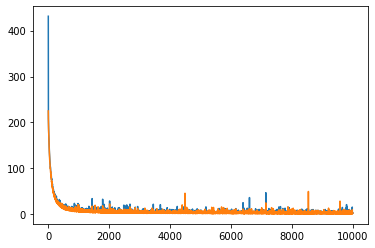

In [34]:
plt.plot(history_loss['train_history_rec'])
plt.plot(history_loss['valid_history_rec'])
plt.show()

In [18]:
gmvae.network.load_state_dict(torch.load(f'smba_gmvae_{num_epochs}.pth'))

<All keys matched successfully>

## Image Reconstruction

In [93]:
original, reconstructed = gmvae.reconstruct_data(train_dl, 15)  

In [21]:
original_int = original.reshape(15, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(15, 16, 16, 12).argmax(axis=-1)

In [22]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [23]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [24]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [25]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

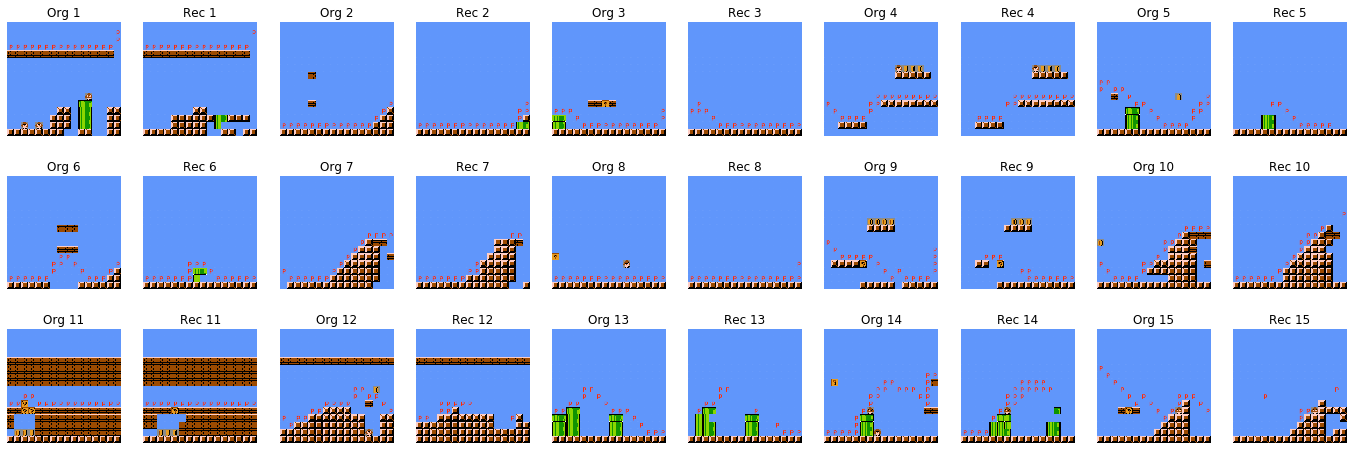

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

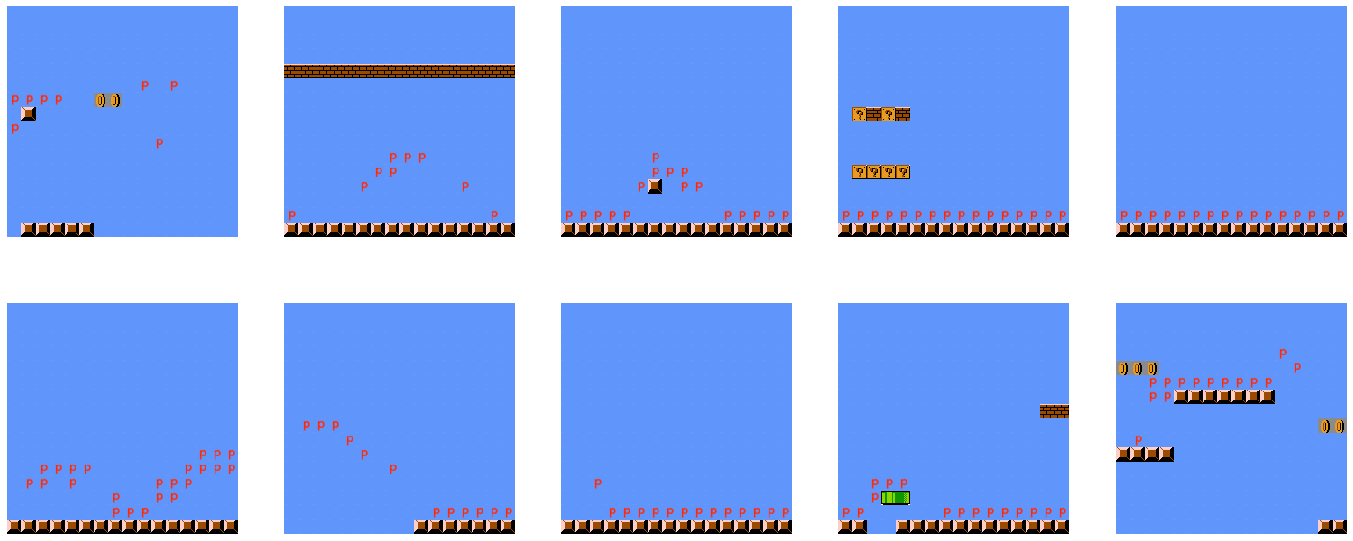

In [101]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,10])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 5
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [19]:
elem_per_category = 10000 // num_components
generated = gmvae.random_generation(elem_per_category)

In [20]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [21]:
generated_int.shape

(10000, 16, 16)

In [31]:
# since this code chunk depends on random seed, it shouldn't be run again
# with open(f'../smba_generations_2_to_7/smba_gmvae_{num_components}.json', 'w+') as json_f:
#     json.dump(generated_int.tolist(), json_f)

In [22]:
with open(f'../qualitative_clustering_analysis/smba_gmvae_{num_components}_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [104]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

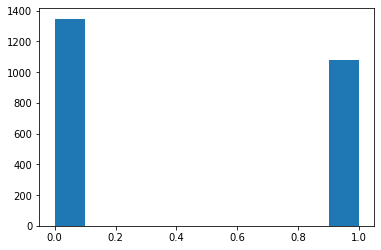

In [105]:
plt.hist(test_labels)
plt.show()

In [106]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000 if len(test_features) > 1000 else len(test_features)
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [107]:
test_labels_subset = test_labels[:first_n]

In [108]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

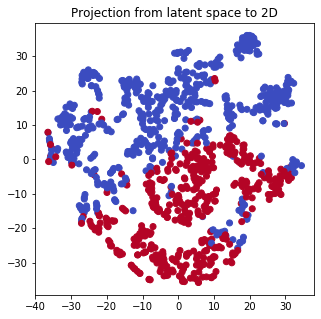

In [109]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_], c=test_labels_subset, cmap='coolwarm')

plt.title('Projection from latent space to 2D')
plt.show()